<a href="https://colab.research.google.com/github/romenlaw/RL-playground/blob/main/rl_playground6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPRL book chapter 12 - Advanced Actor-Critic methods

# Preparation

In [ ]:
!apt -qq install imagemagick
!pip install pybullet

The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw

In [ ]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import pybullet_envs
import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('.', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [ ]:
plt.style.use('fivethirtyeight')
params = {
  'figure.figsize': (15, 8),
  'font.size': 24,
  'legend.fontsize': 20,
  'axes.titlesize': 28,
  'axes.labelsize': 24,
  'xtick.labelsize': 20,
  'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

# Utils

In [ ]:
def get_make_env_fn(**kargs):
  def make_env_fn(env_name,
                  seed=None,
                  render=None,
                  record=False,
                  unwrapped=False,
                  monitor_mode=None, # record video
                  inner_wrappers=None,
                  outer_wrappers=None):
    # tmp_dir = tempfile.mkdtemp()
    env = None
    if render:
      try:
        env = gym.make(env_name, render=render)
      except:
        #print(f"error: render={render}")
        pass
    if env is None: env = gym.make(env_name)
    if seed is not None: env.seed(seed)
    env = env.unwrapped if unwrapped else env
    if inner_wrappers:
      for wrapper in inner_wrappers:
        env = wrapper(env)

    env = gym.wrappers.RecordVideo(env, './video_'+monitor_mode
                                   ) if record else env
    # env = wrappers.Monitor(env, tmp_dir, force=True, # override temp file
    #                        mode=monitor_mode,
    #                        video_callable=lambda e_idx: record
    #                        ) if monitor_mode else env
    if outer_wrappers:
      for wrapper in outer_wrappers:
        env = wrapper(env)
    return env
  return make_env_fn, kargs

In [ ]:
def get_videos_html(env_videos, title, max_n_videos=5):
  '''
  env_videos - list of videos
  title - heading/title of the html heading
  max_n_videos - max number of videos; can be larger or smaller tha len of the env_videos list
  '''
  print(env_videos)
  videos = np.array(env_videos)
  if len(videos) ==0:
    return
  n_videos = max(1, min(max_n_videos, len(videos)))
  idxs = np.linspace(0, len(videos)-1, n_videos).astype(int) if n_videos>1 else [-1,]
  videos = videos[idxs, ...]

  strm = f'<h2>{title}</h2>'
  for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    with open(meta_path) as data_file:
      meta = json.load(data_file)

    html_tag=f"""
    <h3>Episode {meta['episode_id']}</h3>
    <video width="960" height="540" controls>
      <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4"/>
    </video>
    """
    strm += html_tag
  return strm


In [ ]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
  videos = np.array(env_videos)
  if len(videos) == 0:
    return

  n_videos = max(1, min(max_n_videos, len(videos)))
  idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
  videos = videos[idxs,...]

  strm = '<h2>{}<h2>'.format(title)
  for video_path, meta_path in videos:
    basename = os.path.splitext(video_path)[0]
    gif_path = basename + '.gif'
    if not os.path.exists(gif_path):
      ps = subprocess.Popen(
        ('ffmpeg',
          '-i', video_path,
          '-r', '7',
          '-f', 'image2pipe',
          '-vcodec', 'ppm',
          '-crf', '20',
          '-vf', 'scale=512:-1',
          '-'),
        stdout=subprocess.PIPE)
      output = subprocess.check_output(
        ('convert',
          '-coalesce',
          '-delay', '7',
          '-loop', '0',
          '-fuzz', '2%',
          '+dither',
          '-deconstruct',
          '-layers', 'Optimize',
          '-', gif_path),
        stdin=ps.stdout)
      ps.wait()

    gif = io.open(gif_path, 'r+b').read()
    encoded = base64.b64encode(gif)

    with open(meta_path) as data_file:
        meta = json.load(data_file)

    html_tag = """
    <h3>{0}<h3/>
    <img src="data:image/gif;base64,{1}" />"""
    prefix = 'Trial ' if subtitle_eps is None else 'Episode '
    sufix = str(meta['episode_id'] if subtitle_eps is None \
                else subtitle_eps[meta['episode_id']])
    strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
  return strm

In [ ]:
class RenderUint8(gym.Wrapper):
  def __init__(self, env):
    super().__init__(env)
  def reset(self, **kwargs):
    return self.env.reset(**kwargs)
  def render(self, mode='rgb_array'):
    frame = self.env.render(mode=mode)
    return frame.astype(np.uint8)

In [ ]:
class ReplayBuffer():
  def __init__(self, max_size=10000, batch_size=64):
    # states, actions, rewards, next states, done flags
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0 # current index of buffer
    self.size = 0

  def store(self, sample):
    s, a, r, p, d = sample
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d

    self._idx += 1
    self._idx = self._idx % self.max_size

    self.size += 1
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    if batch_size == None:
      batch_size = self.batch_size

    # randomly choose 'batch_size' samples from buffer and put in experiences
    idxs = np.random.choice(self.size, batch_size, replace=False)
    experiences = np.vstack(self.ss_mem[idxs]), \
      np.vstack(self.as_mem[idxs]), \
      np.vstack(self.rs_mem[idxs]), \
      np.vstack(self.ps_mem[idxs]), \
      np.vstack(self.ds_mem[idxs])
    return experiences

  def __len__(self):
    return self.size

In [ ]:
class GreedyStrategy():
  def __init__(self, bounds):
    self.low, self.high = bounds
    self.ratio_noise_injected = 0

  def select_action(self, model, state):
    with torch.no_grad():
      greedy_action = model(state).cpu().detach().data.numpy().squeeze()

    action = np.clip(greedy_action, self.low, self.high)
    return np.reshape(action, self.high.shape)

In DDPG this strategy is used for policy training to balance between exploitation and exploration.

In NFQ, DQN, etc. we use exploration strategy based on q-values - we get the values of action in a given state using a learnt Q-function. In REINFORCE, VPG, etc. we use stochastic policies (i.e. policy itself has randomness), therefore, exploration is on-policy. In DDPG, the agent explores by adding external noise to actions, using off-policy exploration strategies.

Note that in the Pendulum env, the actions are continuous and the action bounds are between -2 and 2. Therefore adding a noise and cipping into bounds make sense.

In [ ]:
class NormalNoiseStrategy():
  def __init__(self, bounds, exploration_noise_ratio=0.1):
    self.low, self.high = bounds
    self.exploration_noise_ratio = exploration_noise_ratio
    self.ratio_noise_injected = 0

  def select_action(self, model, state, max_exploration=False):
    if max_exploration:
      noise_scale = self.high
    else:
      noise_scale = self.exploration_noise_ratio * self.high

    # get the greedy action straight from the network
    with torch.no_grad():
      greedy_action = model(state).cpu().detach().data.numpy().squeeze()

    # Gaussian noise: distribution mean=0, std=noise_scale, output shape=len(self.high)
    noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
    noisy_action = greedy_action + noise
    action = np.clip(noisy_action, self.low, self.high)

    self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
    return action

# DDPG
**Deep Deterministic Policy Gradient** (DDPG) is an improved DQN for continuous action-spaces. Like DQN, it uses replay buffer to train an action-value function in an off-policy manner, and target networks to stabilise training. However, DDPG also trains a policy, which approximates the optimal action. Therefore, DDPG is a deterministic policy-gradient method *restricted to continuous action-spaces*.

Recall the DQN loss function for Q-fn: we sample mini-batch from buffer D, uniformly at random, then calc the TD-target using reward and discounted max value of next state, according to target network.
$$L_i(\theta_i)=\mathbb E_{(s,a,r,s')\sim\mathcal U(\mathcal D)}\left[\left(\underbrace{r+\gamma \max_{a'}Q(s',a';\theta^-)}_{\text{TD target}}-Q(s,a;\theta_i)\right)^2\right]
$$

As in DDQN, the above can be rewritten as:
$$L_i(\theta_i)=\mathbb E_{(s,a,r,s')\sim\mathcal U(\mathcal D)}\left[\left(\underbrace{r+\gamma Q(s',\arg\max_{a'}Q(s',a':\theta^-);\theta^-)}_{\text{TD target}}-Q(s,a;\theta_i)\right)^2\right]
$$

In DDPG, we also sample mini-batch like DQN; but, we don't use argmax of Q, instead we learn a policy μ.
$$L_i(\theta_i)=\mathbb E_{(s,a,r,s')\sim\mathcal U(\mathcal D)}\left[\left(r+\gamma Q(s',\mu(s';\phi^-);\theta^-)-Q(s,a;\theta_i)\right)^2\right]
$$
μ learns a deterministic greedy action in the state in question. Also notice the ϕ is also a target network (-).

## FCQV
fully connected Q-function Value-function network.

In [ ]:
class FCQV(nn.Module): # fully-connected Q-function Value network
  def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super(FCQV, self).__init__()
    self.activation_fc = activation_fc

    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      in_dim = hidden_dims[i]

      # increase the 1st hidden layer dim by the output dim, because we will
      # concat state and action to feed to this layer later, see forward() method
      if i==0:
        in_dim += output_dim

      hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # output of network is a single node representing the value of state-action pair
    # it's not the output_dim (unlike DQN)
    self.output_layer = nn.Linear(hidden_dims[-1], 1)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state, action):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    u = action
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    if not isinstance(u, torch.Tensor):
      u = torch.tensor(u, device=self.device, dtype=torch.float32)
      u = u.unsqueeze(0)
    return x, u

  def forward(self, state, action):
    x, u = self._format(state, action)
    x = self.activation_fc(self.input_layer(x))
    for i, hidden_layer in enumerate(self.hidden_layers):
      # concat actions to states to feed into 1st hidden layer
      if i == 0:
        x = torch.cat((x, u), dim=1)
      x = self.activation_fc(hidden_layer(x))

    # return output, which should be dim=1, value of the state-action pair
    return self.output_layer(x)

  def load(self, experiences):
      states, actions, new_states, rewards, is_terminals = experiences
      states = torch.from_numpy(states).float().to(self.device)
      actions = torch.from_numpy(actions).float().to(self.device)
      new_states = torch.from_numpy(new_states).float().to(self.device)
      rewards = torch.from_numpy(rewards).float().to(self.device)
      is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
      return states, actions, new_states, rewards, is_terminals


## FCDP
fully connected Deterministic Policy network.
This network gives us optimal action in a given state, i.e. network must be differentiable w.r.t. action. Therefore, action must be continuous to make for efficient gradient-based learning.

DDPG's deterministic-policy objective: maximise the expected value of Q-function, using the state and the policy's selected action for that state:
$$J_i(\phi_i)=\mathbb E_{s\sim\mathcal U(\mathcal D)}\left[Q(s,\mu(s;\phi);\theta)\right]
$$
* E_**s**: For this we use the sampled states from the replay buffer
* μ(s;ϕ): query the policy for best action in those states
* Q(...): and then query the Q-function for the q-value

Also notice we don't use target network, but the online network for both the policy (which is the action selection portion) and the value function (which is the action evaluation portion).


In [ ]:
class FCDP(nn.Module):
  def __init__(self, input_dim,
               action_bounds, # tuple of (min, max), to rescale network output from (-1,1) to expected range
               hidden_dims=(32,32),
               activation_fc=F.relu,
               out_activation_fc=F.tanh): # use tanh to squeesh output to (-1, 1)
    super(FCDP, self).__init__()
    self.activation_fc = activation_fc
    self.out_activation_fc = out_activation_fc
    self.env_min, self.env_max = action_bounds

    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)
    self.output_layer = nn.Linear(hidden_dims[-1], len(self.env_max))

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

    self.env_min = torch.tensor(self.env_min, device=self.device, dtype=torch.float32)
    self.env_max = torch.tensor(self.env_max, device=self.device, dtype=torch.float32)
    self.nn_min = self.out_activation_fc(
        torch.Tensor([float('-inf')])
    ).to(self.device)
    self.nn_max = self.out_activation_fc(
        torch.Tensor([float('inf')])
    ).to(self.device)
    # function to rescale the action from -1 to 1 range to the range specific to the environment
    self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
     (self.nn_max - self.nn_min) + self.env_min

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    x = self.output_layer(x)
    x = self.out_activation_fc(x)
    return self.rescale_fn(x)


## DDPG

In [ ]:
class DDPG():
  def __init__(self,
               replay_buffer_fn,
               policy_model_fn,
               policy_max_grad_norm,
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn,
               value_max_grad_norm,
               value_optimizer_fn,
               value_optimizer_lr,
               training_strategy_fn,
               evaluation_strategy_fn,
               n_warmup_batches,
               update_target_every_steps,
               tau):
    self.replay_buffer_fn = replay_buffer_fn

    self.policy_model_fn = policy_model_fn
    self.policy_max_grad_norm = policy_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_max_grad_norm = value_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.training_strategy_fn = training_strategy_fn
    self.evaluation_strategy_fn = evaluation_strategy_fn

    self.n_warmup_batches = n_warmup_batches
    self.update_target_every_steps = update_target_every_steps
    self.tau = tau

  def optimize_model(self, experiences): # experiences is mini-batch of experiences
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    argmax_a_q_sp = self.target_policy_model(next_states)
    max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
    target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
    q_sa = self.online_value_model(states, actions)
    td_error = q_sa - target_q_sa.detach()
    value_loss = td_error.pow(2).mul(0.5).mean()
    self.value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(),
                                    self.value_max_grad_norm)
    self.value_optimizer.step()

    argmax_a_q_s = self.online_policy_model(states)
    max_a_q_s = self.online_value_model(states, argmax_a_q_s)
    policy_loss = -max_a_q_s.mean()
    self.policy_optimizer.zero_grad()
    policy_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(),
                                    self.policy_max_grad_norm)
    self.policy_optimizer.step()

  def interaction_step(self, state, env):
    min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
    action = self.training_strategy.select_action(self.online_policy_model,
                                                  state,
                                                  # max_exploration
                                                  len(self.replay_buffer) < min_samples)
    new_state, reward, is_terminal, info = env.step(action)
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))
    self.replay_buffer.store(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected
    return new_state, is_terminal

  def update_networks(self, tau=None):
    tau = self.tau if tau is None else tau
    for target, online in zip (self.target_value_model.parameters(),
                               self.online_value_model.parameters()):
      target_ratio = (1.0 - tau) * target.data
      online_ratio = tau * online.data
      mixed_weights = target_ratio + online_ratio
      target.data.copy_(mixed_weights)

    for target.online in zip (self.target_policy_model.parameters(),
                              self.online_policy_model.parameters()):
      target_ratio = (1.0 - tau) * target.data
      online_ratio = tau * online.data
      mixed_weights = target_ratio + online_ratio
      target.data.copy_(mixed_weights)

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
    action_bounds = env.action_space.low, env.action_space.high
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.target_value_model = self.value_model_fn(nS, nA)
    self.online_value_model = self.value_model_fn(nS, nA)
    self.target_policy_model = self.policy_model_fn(nS, action_bounds)
    self.online_policy_model = self.policy_model_fn(nS, action_bounds)
    self.update_networks(tau=1.0)
    self.value_optimizer = self.value_optimizer_fn(self.online_value_model,
                                                   self.value_optimizer_lr)
    self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model,
                                                     self.policy_optimizer_lr)

    self.replay_buffer = self.replay_buffer_fn()
    self.training_strategy = training_strategy_fn(action_bounds)
    self.evaluation_strategy = evaluation_strategy_fn(action_bounds)

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      for step in count():
        state, is_terminal = self.interaction_step(state, env)

        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) > min_samples:
          experiences = self.replay_buffer.sample()
          experiences = self.online_value_model.load(experiences)
          self.optimize_model(experiences)

        if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
          self.update_networks()

        if is_terminal:
          gc.collect()
          break

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.online_policy_model, env)
      self.save_checkpoint(episode-1, self.online_policy_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f} in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        a = self.evaluation_strategy.select_action(eval_policy_model, s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.online_policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.online_policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


## Train DDPG on Pendulum
Pendulum is a simple environment. The state space is a 3-dim vector:
1. $\cos(\theta)$
2. $\sin(\theta)$
3. $\theta_{dot}$: angular speed

The action space is a single continuous variabe fro -2 to 2 indicating the joint effort (either clockwise or anti-clockwise).

The goal is to remain perfectly balanced upright with no effort, where agent receives 0 reward. The highest cost (lowest reward) is approx -16. The reward is calculated as
$$reward = -(\theta^2+0.1\times\theta_{dot}^2+0.001\times action^2)$$

This is a continuous task, with no terminak state. However, the env times out after 200 steps. Hence, the env is unsolved, i.e. no target return. A return of -150 is a reasonable threshold to hit.

In [ ]:
ddpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
    'env_name': 'Pendulum-v1',
    'gamma': 0.99,
    'max_minutes': 40,
    'max_episodes': 600,
    'goal_mean_100_reward': -150
  }

  policy_model_fn = lambda nS, bounds: FCDP(nS, bounds, hidden_dims=(256,256))
  policy_max_grad_norm = float('inf')
  policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
  policy_optimizer_lr = 3e-4

  value_model_fn = lambda nS, nA: FCQV(nS, nA, hidden_dims=(256,256))
  value_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
  value_optimizer_lr = 6e-4

  training_strategy_fn = lambda bounds: NormalNoiseStrategy(bounds, exploration_noise_ratio=0.1)
  evaluation_strategy_fn = lambda bounds: GreedyStrategy(bounds)

  replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=256)
  n_warmup_batches = 5
  update_target_every_steps = 1
  tau = 0.005

  env_name, gamma, max_minutes, \
  max_episodes, goal_mean_100_reward = environment_settings.values()

  agent = DDPG(replay_buffer_fn,
                policy_model_fn,
                policy_max_grad_norm,
                policy_optimizer_fn,
                policy_optimizer_lr,
                value_model_fn,
                value_max_grad_norm,
                value_optimizer_fn,
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_target_every_steps,
                tau)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallclock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
  ddpg_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent
ddpg_results = np.array(ddpg_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

el 00:00:03, ep 0000, ts 000200, ar 10 -1293.6±000.0, 100 -1293.6±000.0, ex 100 0.3±0.0, ev -1241.4±000.0
el 00:05:03, ep 0063, ts 012800, ar 10 -183.6±097.7, 100 -454.7±490.8, ex 100 0.1±0.1, ev -466.8±560.5
el 00:10:06, ep 0122, ts 024600, ar 10 -148.2±110.3, 100 -167.8±103.7, ex 100 0.0±0.0, ev -159.8±101.1
el 00:15:10, ep 0180, ts 036200, ar 10 -1380.9±304.1, 100 -496.3±614.5, ex 100 0.0±0.0, ev -556.3±664.5
el 00:20:11, ep 0236, ts 047400, ar 10 -1334.6±265.6, 100 -1223.6±577.2, ex 100 0.0±0.0, ev -1309.4±584.4
el 00:25:15, ep 0292, ts 058600, ar 10 -1409.2±175.3, 100 -1458.4±227.5, ex 100 0.0±0.0, ev -1504.1±221.2
el 00:30:15, ep 0345, ts 069200, ar 10 -1232.3±337.5, 100 -1373.8±285.6, ex 100 0.0±0.0, ev -1432.1±261.5
el 00:35:20, ep 0398, ts 079800, ar 10 -1143.6±360.9, 100 -1237.7±350.7, ex 100 0.0±0.0, ev -1316.6±320.8
el 00:40:03, ep 0447, ts 089600, ar 10 -1418.0±126.5, 100 -1267.1±333.4, ex 100 0.0±0.0, ev -1278.6±317.6
--> reached_max_minutes ✕
Training complete.
Final eva

Above debug messages:
* el = elapsed time
* ep = episode
* ts = total steps
* ar 10 = last 10 reward mean, std
* 100 = last 100 reward mean, std
* ex = last 100 exploration ratio mean, std
* ev = last 100 eval score mean, std

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specif


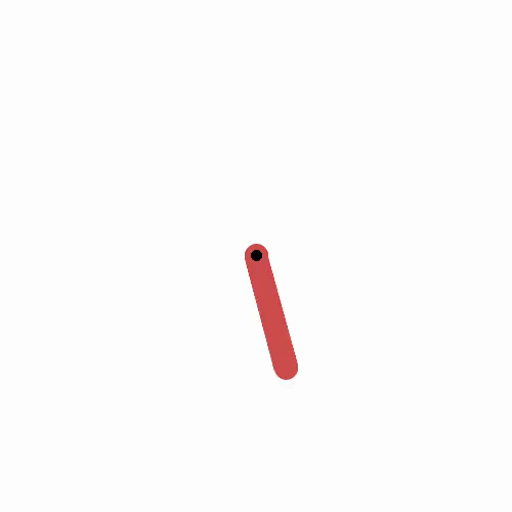
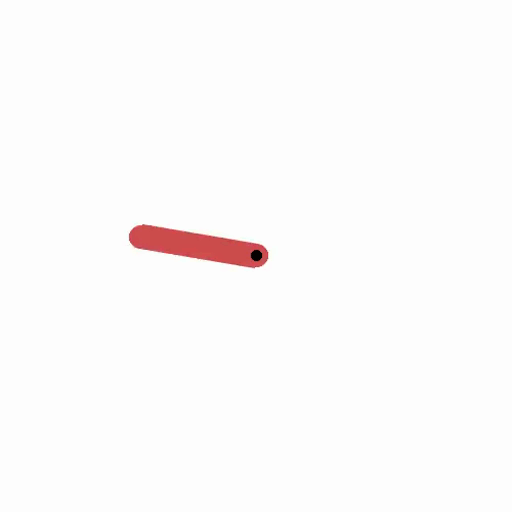

In [ ]:
best_agent.demo_progression()

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is dep


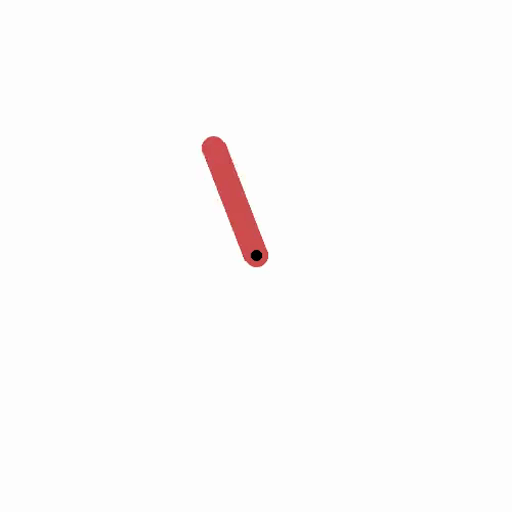
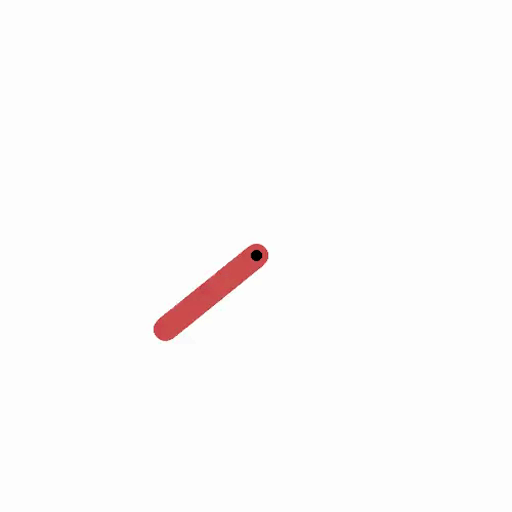

In [ ]:
best_agent.demo_last()

In [ ]:
ddpg_max_t, ddpg_max_r, ddpg_max_s, \
ddpg_max_sec, ddpg_max_rt = np.max(ddpg_results, axis=0).T
ddpg_min_t, ddpg_min_r, ddpg_min_s, \
ddpg_min_sec, ddpg_min_rt = np.min(ddpg_results, axis=0).T
ddpg_mean_t, ddpg_mean_r, ddpg_mean_s, \
ddpg_mean_sec, ddpg_mean_rt = np.mean(ddpg_results, axis=0).T
ddpg_x = np.arange(len(ddpg_mean_s))

In [ ]:
ddpg_root_dir = os.path.join(RESULTS_DIR, 'ddpg')
not os.path.exists(ddpg_root_dir) and os.makedirs(ddpg_root_dir)

np.save(os.path.join(ddpg_root_dir, 'x'), ddpg_x)

np.save(os.path.join(ddpg_root_dir, 'max_r'), ddpg_max_r)
np.save(os.path.join(ddpg_root_dir, 'min_r'), ddpg_min_r)
np.save(os.path.join(ddpg_root_dir, 'mean_r'), ddpg_mean_r)

np.save(os.path.join(ddpg_root_dir, 'max_s'), ddpg_max_s)
np.save(os.path.join(ddpg_root_dir, 'min_s'), ddpg_min_s )
np.save(os.path.join(ddpg_root_dir, 'mean_s'), ddpg_mean_s)

np.save(os.path.join(ddpg_root_dir, 'max_t'), ddpg_max_t)
np.save(os.path.join(ddpg_root_dir, 'min_t'), ddpg_min_t)
np.save(os.path.join(ddpg_root_dir, 'mean_t'), ddpg_mean_t)

np.save(os.path.join(ddpg_root_dir, 'max_sec'), ddpg_max_sec)
np.save(os.path.join(ddpg_root_dir, 'min_sec'), ddpg_min_sec)
np.save(os.path.join(ddpg_root_dir, 'mean_sec'), ddpg_mean_sec)

np.save(os.path.join(ddpg_root_dir, 'max_rt'), ddpg_max_rt)
np.save(os.path.join(ddpg_root_dir, 'min_rt'), ddpg_min_rt)
np.save(os.path.join(ddpg_root_dir, 'mean_rt'), ddpg_mean_rt)

## Load from files

In [ ]:
!rm -f results/ddpg/*
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/max_r.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/max_rt.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/max_s.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/max_sec.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/max_t.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/mean_r.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/mean_rt.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/mean_s.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/mean_sec.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/mean_t.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/min_r.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/min_rt.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/min_s.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/min_sec.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/min_t.npy
!wget -nv -P results/ddpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddpg/x.npy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2025-01-05 00:17:53 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_r.npy [80128/80128] -> "results/reinforce/max_r.npy" [1]
2025-01-05 00:17:53 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_rt.npy [80128/80128] -> "results/reinforce/max_rt.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_s.npy [80128/80128] -> "results/reinforce/max_s.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_sec.npy [80128/80128] -> "results/reinforce/max_sec.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_t.npy [80128/80128] -> "results/reinforce/max_t.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/mean_r.npy [80128/80128] -> "results/reinforce/mean_r

In [ ]:
ddpg_root_dir = os.path.join(RESULTS_DIR, 'ddpg')

ddpg_x = np.load(os.path.join(ddpg_root_dir, 'x.npy'))

ddpg_max_r = np.load(os.path.join(ddpg_root_dir, 'max_r.npy'))
ddpg_min_r = np.load(os.path.join(ddpg_root_dir, 'min_r.npy'))
ddpg_mean_r = np.load(os.path.join(ddpg_root_dir, 'mean_r.npy'))

ddpg_max_s = np.load(os.path.join(ddpg_root_dir, 'max_s.npy'))
ddpg_min_s = np.load(os.path.join(ddpg_root_dir, 'min_s.npy'))
ddpg_mean_s = np.load(os.path.join(ddpg_root_dir, 'mean_s.npy'))

ddpg_max_t = np.load(os.path.join(ddpg_root_dir, 'max_t.npy'))
ddpg_min_t = np.load(os.path.join(ddpg_root_dir, 'min_t.npy'))
ddpg_mean_t = np.load(os.path.join(ddpg_root_dir, 'mean_t.npy'))

ddpg_max_sec = np.load(os.path.join(ddpg_root_dir, 'max_sec.npy'))
ddpg_min_sec = np.load(os.path.join(ddpg_root_dir, 'min_sec.npy'))
ddpg_mean_sec = np.load(os.path.join(ddpg_root_dir, 'mean_sec.npy'))

ddpg_max_rt = np.load(os.path.join(ddpg_root_dir, 'max_rt.npy'))
ddpg_min_rt = np.load(os.path.join(ddpg_root_dir, 'min_rt.npy'))
ddpg_mean_rt = np.load(os.path.join(ddpg_root_dir, 'mean_rt.npy'))

## Plotting DDPG

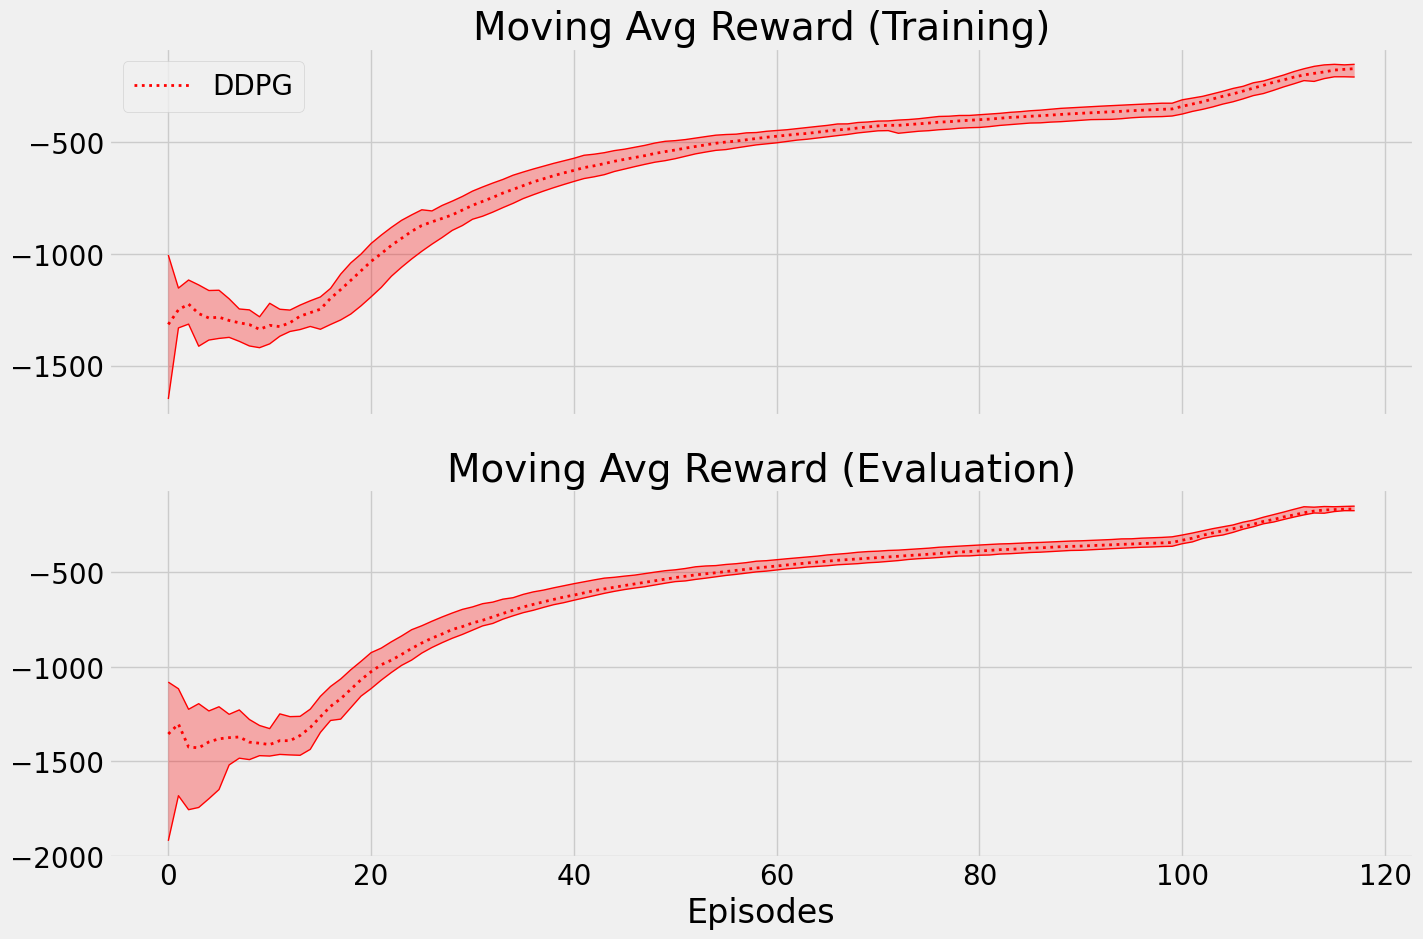

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# DDPG
axs[0].plot(ddpg_max_r, 'r', linewidth=1)
axs[0].plot(ddpg_min_r, 'r', linewidth=1)
axs[0].plot(ddpg_mean_r, 'r:', label='DDPG', linewidth=2)
axs[0].fill_between(
    ddpg_x, ddpg_min_r, ddpg_max_r, facecolor='r', alpha=0.3)

axs[1].plot(ddpg_max_s, 'r', linewidth=1)
axs[1].plot(ddpg_min_s, 'r', linewidth=1)
axs[1].plot(ddpg_mean_s, 'r:', label='DDPG', linewidth=2)
axs[1].fill_between(
    ddpg_x, ddpg_min_s, ddpg_max_s, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# TD3
Twin-Delayed DDPG (TD3) improves performance on DDPG:
1. it adds double learning technique, similar to DDQN, but with twin network architecture.
2. adds noise not only to action passed into network, but also target actions, making policy network more robust against approximation errors
3. delays updates to policy network, its target network, and the twin target network, s.t. the twin network updates more frequently.

## Twin Network - FCTQV
In TD3 we have 2 separate streams only sharing the optimizer (note, in other arch, e.g. with CNN, the common features can be shared too; those are harder to train).

The  twin networks' loss is the sum of MSEs of each stream:
$$J_i(\theta_i^a)=\mathbb E_{(s,a,r,s')\sim \mathcal{U(D)}}\left[\left(\mathcal{TWIN}^{target}-Q(s,a;\theta_i^a)\right)^2\right]
$$
$$J_i(\theta_i^b)=\mathbb E_{(s,a,r,s')\sim \mathcal{U(D)}}\left[\left(\mathcal{TWIN}^{target}-Q(s,a;\theta_i^b)\right)^2\right]
$$
We calculate the target using the min of both streams: notice it uses target networks ('-') for both the policy and value netwrorks.
$$
\mathcal{TWIN}^{target}=r+γ\min_nQ(s',\mu(x';\phi^-);\theta^{n,-})
$$

In [ ]:
#fully-connected Twin Q-value network

class FCTQV(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super().__init__()
    self.activation_fc = activation_fc

    # build two separate streams / layers
    self.input_layer_a = nn.Linear(input_dim + output_dim, hidden_dims[0])
    self.input_layer_b = nn.Linear(input_dim + output_dim, hidden_dims[0])

    self.hidden_layers_a = nn.ModuleList()
    self.hidden_layers_b = nn.ModuleList()

    for i in range(len(hidden_dims)-1):
      hid_a = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      hid_b = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers_a.append(hid_a)
      self.hidden_layers_b.append(hid_b)

    self.output_layer_a = nn.Linear(hidden_dims[-1], 1) # output_dim is 1 (value of the state)
    self.output_layer_b = nn.Linear(hidden_dims[-1], 1)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state, action):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    u = action
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    if not isinstance(u, torch.Tensor):
      u = torch.tensor(u, device=self.device, dtype=torch.float32)
      u = u.unsqueeze(0)
    return x, u

  def forward(self, state, action):
    x, u = self._format(state, action)
    # concat state and action, and pass to each stream
    x = torch.cat([x, u], dim=1)
    xa = self.activation_fc(self.input_layer_a(x))
    xb = self.activation_fc(self.input_layer_b(x))

    for hidden_layer_a, hidden_layer_b in zip( self.hidden_layers_a, self.hidden_layers_b):
      xa = self.activation_fc(hidden_layer_a(xa))
      xb = self.activation_fc(hidden_layer_b(xb))
    xa = self.output_layer(xa)
    xb = self.output_layer(xb)
    return xa, xb

  # similar to forward() above, but only pass through the stream a network.
  def Qa(self, state, action):
    x, u = self._format(state, action)
    x = torch.cat([x, u], dim=1)
    xa = self.activation_fc(self.input_layer_a(x))
    for hidden_layer_a in self.hidden_layers_a:
      xa = self.activation_fc(hidden_layer_a(xa))
    xa = self.output_layer(xa)

    return xa, xb

  # load experience into torch device (either cpu, gpu)
  def load(self, experiences):
    states, actions, new_states, rewards, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).float().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, new_states, rewards, is_terminals

## Add Noise
same as NormalNoiseStrategy() with added linear decay.

In [ ]:
class NormalNoiseDecayStrategy():
  def __init__(self, bounds, # ([low], [high])
               init_noise_ratio=0.5, min_noise_ratio=0.1, decay_steps=10000):
    self.t = 0  # timestep
    self.low, self.high = bounds
    self.noise_ratio = init_noise_ratio
    self.init_noise_ratio = init_noise_ratio
    self.min_noise_ratio = min_noise_ratio
    self.decay_steps = decay_steps
    self.ratio_noise_injected = 0

  def _noise_ratio_update(self):
    noise_ratio = 1 - self.t / self.decay_steps
    noise_ratio = (self.init_noise_ratio - self.min_noise_ratio) * noise_ratio + self.min_noise_ratio
    noise_ratio = np.clip(noise_ratio, self.min_noise_ratio, self.init_noise_ratio)
    self.t += 1
    return noise_ratio

  def select_action(self, model, state, max_exploration=False):
    if max_exploration:
      noise_scale = self.high
    else:
      noise_scale = self.noise_ratio * self.high

    with torch.no_grad():
      greedy_action = model(state).cpu().detach().data.numpy().squeeze()

    noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
    noisy_action = greedy_action + noise
    action = np.clip(noisy_action, self.low, self.high)

    self.noise_ratio = self._noise_ratio_update()
    self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
    return action

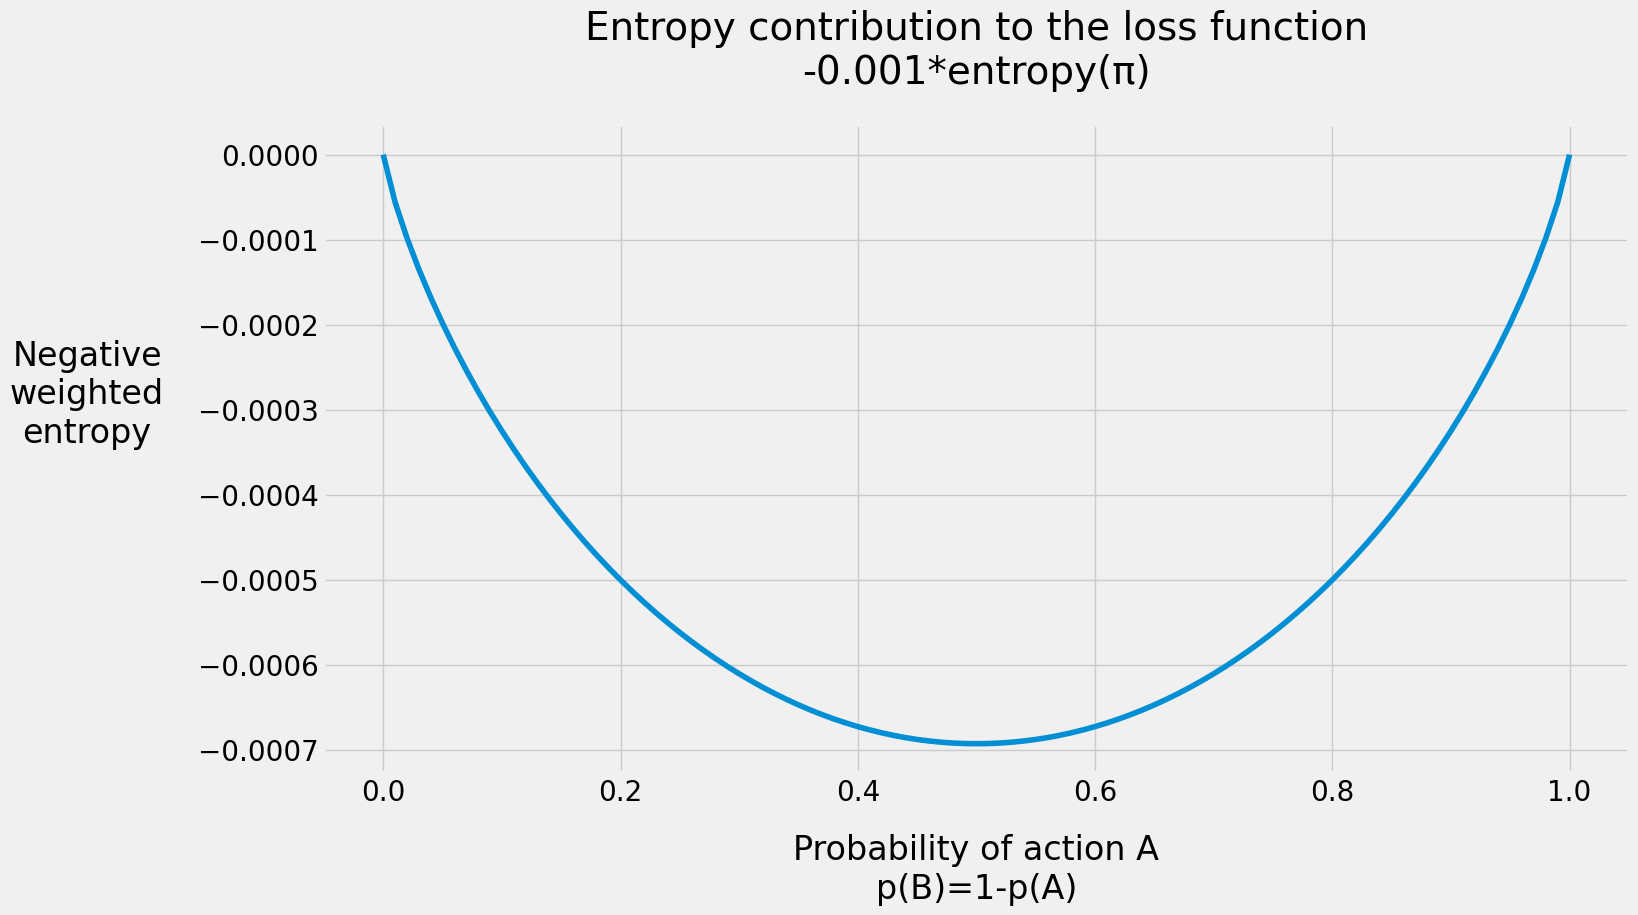

In [ ]:
# by default init_noise_ratio=0.5, min_noise_ratio=0.1, decay in 10000 steps
s = NormalNoiseDecayStrategy(([-2],[2]))
plt.plot([s._noise_ratio_update() for _ in range(50000)])
plt.title('Normal Noise Linear ratio')
plt.xticks(rotation=45)
plt.show()

## TD3 Target

In TD3 we add noise not only to the action for exploration (see NormalNoiseDecayStrategy() above), but also to action used to calculate the target.

Training the policy with noisy targets can be seen as a regularizer because now the network is forced to generalize over similar actions. This technique prevents the policy network from converging to incorrect actions since early on during training, Q-functions can prematurely
inaccurately value some actions. The noise over the actions spreads that value over a more inclusive range of actions than otherwise.

Define a clamp function as following:
$$clamp(a,l,h)=\max(\min(x, h), l)
$$
In TD3, we smooth the action by adding clipped Gaussian noise ϵ: ($a_l, a_h$ are from envrionment)
$$a'^{,smooth}=clamp(\left[\mu(s';\phi^-)+clamp(ϵ, ϵ_l, ϵ_h)\right], a_l, a_h)
$$
Use the smoothed action to calculate target:
$$\mathcal{TD}3^{target}=r+γ\min_nQ(s', a'^{,smooth}; θ^{n,-})
$$

See optimize_mode() in TD3 below.

In [ ]:
class TD3():
  def __init__(self,
               replay_buffer_fn,
               policy_model_fn,
               policy_max_grad_norm,
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn,
               value_max_grad_norm,
               value_optimizer_fn,
               value_optimizer_lr,
               training_strategy_fn,
               evaluation_strategy_fn,
               n_warmup_batches,
               update_value_target_every_steps,
               update_policy_target_every_steps,
               train_policy_every_steps,
               tau,
               policy_noise_ratio,
               policy_noise_clip_ratio):
    self.replay_buffer_fn = replay_buffer_fn

    self.policy_model_fn = policy_model_fn
    self.policy_max_grad_norm = policy_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_max_grad_norm = value_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.training_strategy_fn = training_strategy_fn
    self.evaluation_strategy_fn = evaluation_strategy_fn

    self.n_warmup_batches = n_warmup_batches
    self.update_value_target_every_steps = update_value_target_every_steps
    self.update_policy_target_every_steps = update_policy_target_every_steps
    self.train_policy_every_steps = train_policy_every_steps

    self.tau = tau
    self.policy_noise_ratio = policy_noise_ratio
    self.policy_noise_clip_ratio = policy_noise_clip_ratio

  def optimize_model(self, experiences): # experiences is mini-batch of experiences
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    with torch.no_grad():
      # the target_policy_model is FCDP, which takes in bounds (env_min, max)
      env_min = self.target_policy_model.env_min
      env_max = self.target_policy_model.env_max

      # get noise and scale it to the range of the actions
      a_ran = env_max - env_min
      a_noise = torch.randn_like(actions) * self.policy_noise_ratio * a_ran
      # get the noise min and max used for clipping
      n_min = env_min * self.policy_noise_clip_ratio
      n_max = env_max * self.policy_noise_clip_ratio
      a_noise = torch.clamp(a_noise, n_min, n_max)

      # get action from the target policy model, then add noise and clip it
      argmax_a_q_sp = self.target_policy_model(next_states)
      noisy_argmax_a_q_sp = torch.clamp(argmax_a_q_sp + a_noise, env_min, env_max)

      # the target_value_model is FCTQV, which returns two streams' values
      max_a_q_sp_a, max_a_q_sp_b = self.target_value_model(next_states, noisy_argmax_a_q_sp)
      max_a_q_sp = torch.min(max_a_q_sp_a, max_a_q_sp_b)
      target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

    # again, the value_model is FCTQV, which returns both streams' values
    q_sa_a, q_sa_b = self.online_value_model(states, actions)
    td_error = q_sa - target_q_sa.detach()
    value_loss = td_error.pow(2).mul(0.5).mean()
    self.value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(),
                                    self.value_max_grad_norm)
    self.value_optimizer.step()

    argmax_a_q_s = self.online_policy_model(states)
    max_a_q_s = self.online_value_model(states, argmax_a_q_s)
    policy_loss = -max_a_q_s.mean()
    self.policy_optimizer.zero_grad()
    policy_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(),
                                    self.policy_max_grad_norm)
    self.policy_optimizer.step()

  def interaction_step(self, state, env):
    min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
    action = self.training_strategy.select_action(self.online_policy_model,
                                                  state,
                                                  # max_exploration
                                                  len(self.replay_buffer) < min_samples)
    new_state, reward, is_terminal, info = env.step(action)
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))
    self.replay_buffer.store(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected
    return new_state, is_terminal

  def update_networks(self, tau=None):
    tau = self.tau if tau is None else tau
    for target, online in zip (self.target_value_model.parameters(),
                               self.online_value_model.parameters()):
      target_ratio = (1.0 - tau) * target.data
      online_ratio = tau * online.data
      mixed_weights = target_ratio + online_ratio
      target.data.copy_(mixed_weights)

    for target.online in zip (self.target_policy_model.parameters(),
                              self.online_policy_model.parameters()):
      target_ratio = (1.0 - tau) * target.data
      online_ratio = tau * online.data
      mixed_weights = target_ratio + online_ratio
      target.data.copy_(mixed_weights)

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
    action_bounds = env.action_space.low, env.action_space.high
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.target_value_model = self.value_model_fn(nS, nA)
    self.online_value_model = self.value_model_fn(nS, nA)
    self.target_policy_model = self.policy_model_fn(nS, action_bounds)
    self.online_policy_model = self.policy_model_fn(nS, action_bounds)
    self.update_networks(tau=1.0)
    self.value_optimizer = self.value_optimizer_fn(self.online_value_model,
                                                   self.value_optimizer_lr)
    self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model,
                                                     self.policy_optimizer_lr)

    self.replay_buffer = self.replay_buffer_fn()
    self.training_strategy = training_strategy_fn(action_bounds)
    self.evaluation_strategy = evaluation_strategy_fn(action_bounds)

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      for step in count():
        state, is_terminal = self.interaction_step(state, env)

        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) > min_samples:
          experiences = self.replay_buffer.sample()
          experiences = self.online_value_model.load(experiences)
          self.optimize_model(experiences)

        if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
          self.update_networks()

        if is_terminal:
          gc.collect()
          break

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.online_policy_model, env)
      self.save_checkpoint(episode-1, self.online_policy_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f} in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        a = self.evaluation_strategy.select_action(eval_policy_model, s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.online_policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.online_policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


## Train VPG

In [ ]:
vpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 20,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
  policy_optimizer_lr = 5e-4

  value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 7e-4

  entropy_loss_weight = 1e-3

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = VPG(policy_model_fn,
              policy_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              value_model_fn,
              value_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              entropy_loss_weight)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  vpg_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent

vpg_results = np.array(vpg_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.5±0.0, ev 010.0±000.0
el 00:01:00, ep 0156, ts 017428, ar 10 188.2±104.3, 100 152.8±093.6, ex 100 0.3±0.0, ev 365.5±128.4
el 00:02:00, ep 0248, ts 043358, ar 10 382.7±094.8, 100 274.7±127.0, ex 100 0.3±0.0, ev 423.6±102.4
el 00:03:01, ep 0319, ts 071595, ar 10 480.2±044.8, 100 381.7±115.3, ex 100 0.3±0.0, ev 455.2±079.7
el 00:03:48, ep 0368, ts 095020, ar 10 495.1±014.7, 100 443.7±090.4, ex 100 0.2±0.0, ev 475.3±062.3
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 492.99±27.07 in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.

el 00:00:00, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 010.0±000.0
el 00:01:00, ep 0167, ts 016023, ar 10 207.0±080.0, 100 132.8±078.1, ex 100 0.3±0.0, ev 342.5±137.8
el 00:02:00, ep 0246, ts 035978, ar 10 417.5±119.0, 100 242.1±112.9, ex 100 0.3±0.0, ev 414.0±112.5
el 00:03:00, ep 0307, ts 057838, ar 10

error: render=True



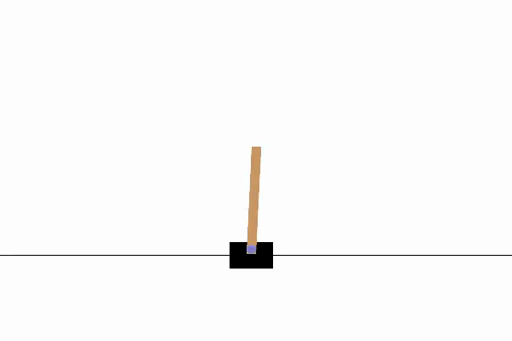
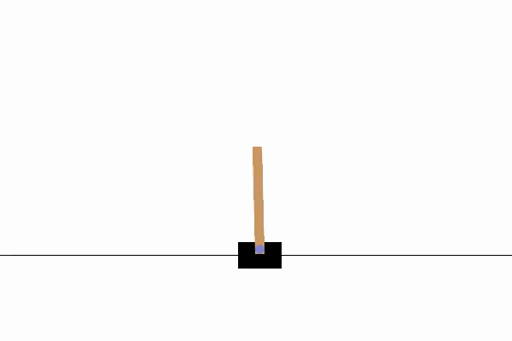

In [ ]:
best_agent.demo_progression()

error: render=True



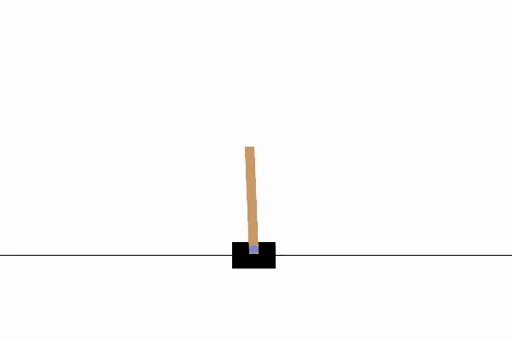
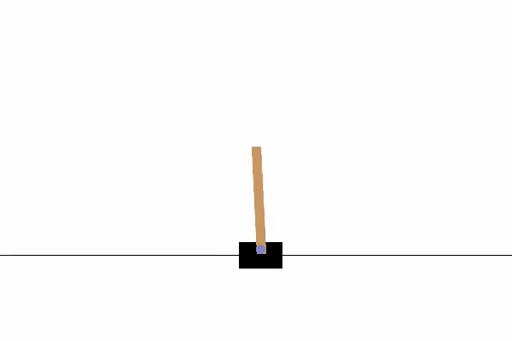

In [ ]:
best_agent.demo_last()

In [ ]:
vpg_max_t, vpg_max_r, vpg_max_s, vpg_max_sec, vpg_max_rt = np.max(vpg_results, axis=0).T
vpg_min_t, vpg_min_r, vpg_min_s, vpg_min_sec, vpg_min_rt = np.min(vpg_results, axis=0).T
vpg_mean_t, vpg_mean_r, vpg_mean_s, vpg_mean_sec, vpg_mean_rt = np.mean(vpg_results, axis=0).T
vpg_x = np.arange(np.max((len(vpg_mean_s), len(reinforce_mean_s))))

In [ ]:
vpg_root_dir = os.path.join(RESULTS_DIR, 'vpg')
not os.path.exists(vpg_root_dir) and os.makedirs(vpg_root_dir)

np.save(os.path.join(vpg_root_dir, 'x'), vpg_x)

np.save(os.path.join(vpg_root_dir, 'max_r'), vpg_max_r)
np.save(os.path.join(vpg_root_dir, 'min_r'), vpg_min_r)
np.save(os.path.join(vpg_root_dir, 'mean_r'), vpg_mean_r)

np.save(os.path.join(vpg_root_dir, 'max_s'), vpg_max_s)
np.save(os.path.join(vpg_root_dir, 'min_s'), vpg_min_s )
np.save(os.path.join(vpg_root_dir, 'mean_s'), vpg_mean_s)

np.save(os.path.join(vpg_root_dir, 'max_t'), vpg_max_t)
np.save(os.path.join(vpg_root_dir, 'min_t'), vpg_min_t)
np.save(os.path.join(vpg_root_dir, 'mean_t'), vpg_mean_t)

np.save(os.path.join(vpg_root_dir, 'max_sec'), vpg_max_sec)
np.save(os.path.join(vpg_root_dir, 'min_sec'), vpg_min_sec)
np.save(os.path.join(vpg_root_dir, 'mean_sec'), vpg_mean_sec)

np.save(os.path.join(vpg_root_dir, 'max_rt'), vpg_max_rt)
np.save(os.path.join(vpg_root_dir, 'min_rt'), vpg_min_rt)
np.save(os.path.join(vpg_root_dir, 'mean_rt'), vpg_mean_rt)

## Load from files

In [ ]:
!rm -f results/vpg/*
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_r.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_rt.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_s.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_sec.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_t.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_r.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_rt.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_s.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_sec.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_t.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_r.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_rt.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_s.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_sec.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_t.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/x.npy

2025-01-05 00:17:57 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_r.npy [80128/80128] -> "results/vpg/max_r.npy" [1]
2025-01-05 00:17:58 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_rt.npy [80128/80128] -> "results/vpg/max_rt.npy" [1]
2025-01-05 00:17:58 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_s.npy [80128/80128] -> "results/vpg/max_s.npy" [1]
2025-01-05 00:17:58 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_sec.npy [80128/80128] -> "results/vpg/max_sec.npy" [1]
2025-01-05 00:17:59 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_t.npy [80128/80128] -> "results/vpg/max_t.npy" [1]
2025-01-05 00:17:59 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_r.npy [80128/80128] -> "results/vpg/mean_r.npy" [1]
2025-01-05 00:17:59 URL:https://raw.githubusercontent.com/rome

In [ ]:
vpg_root_dir = os.path.join(RESULTS_DIR, 'vpg')

vpg_x = np.load(os.path.join(vpg_root_dir, 'x.npy'))

vpg_max_r = np.load(os.path.join(vpg_root_dir, 'max_r.npy'))
vpg_min_r = np.load(os.path.join(vpg_root_dir, 'min_r.npy'))
vpg_mean_r = np.load(os.path.join(vpg_root_dir, 'mean_r.npy'))

vpg_max_s = np.load(os.path.join(vpg_root_dir, 'max_s.npy'))
vpg_min_s = np.load(os.path.join(vpg_root_dir, 'min_s.npy'))
vpg_mean_s = np.load(os.path.join(vpg_root_dir, 'mean_s.npy'))

vpg_max_t = np.load(os.path.join(vpg_root_dir, 'max_t.npy'))
vpg_min_t = np.load(os.path.join(vpg_root_dir, 'min_t.npy'))
vpg_mean_t = np.load(os.path.join(vpg_root_dir, 'mean_t.npy'))

vpg_max_sec = np.load(os.path.join(vpg_root_dir, 'max_sec.npy'))
vpg_min_sec = np.load(os.path.join(vpg_root_dir, 'min_sec.npy'))
vpg_mean_sec = np.load(os.path.join(vpg_root_dir, 'mean_sec.npy'))

vpg_max_rt = np.load(os.path.join(vpg_root_dir, 'max_rt.npy'))
vpg_min_rt = np.load(os.path.join(vpg_root_dir, 'min_rt.npy'))
vpg_mean_rt = np.load(os.path.join(vpg_root_dir, 'mean_rt.npy'))


## Plotting VPG

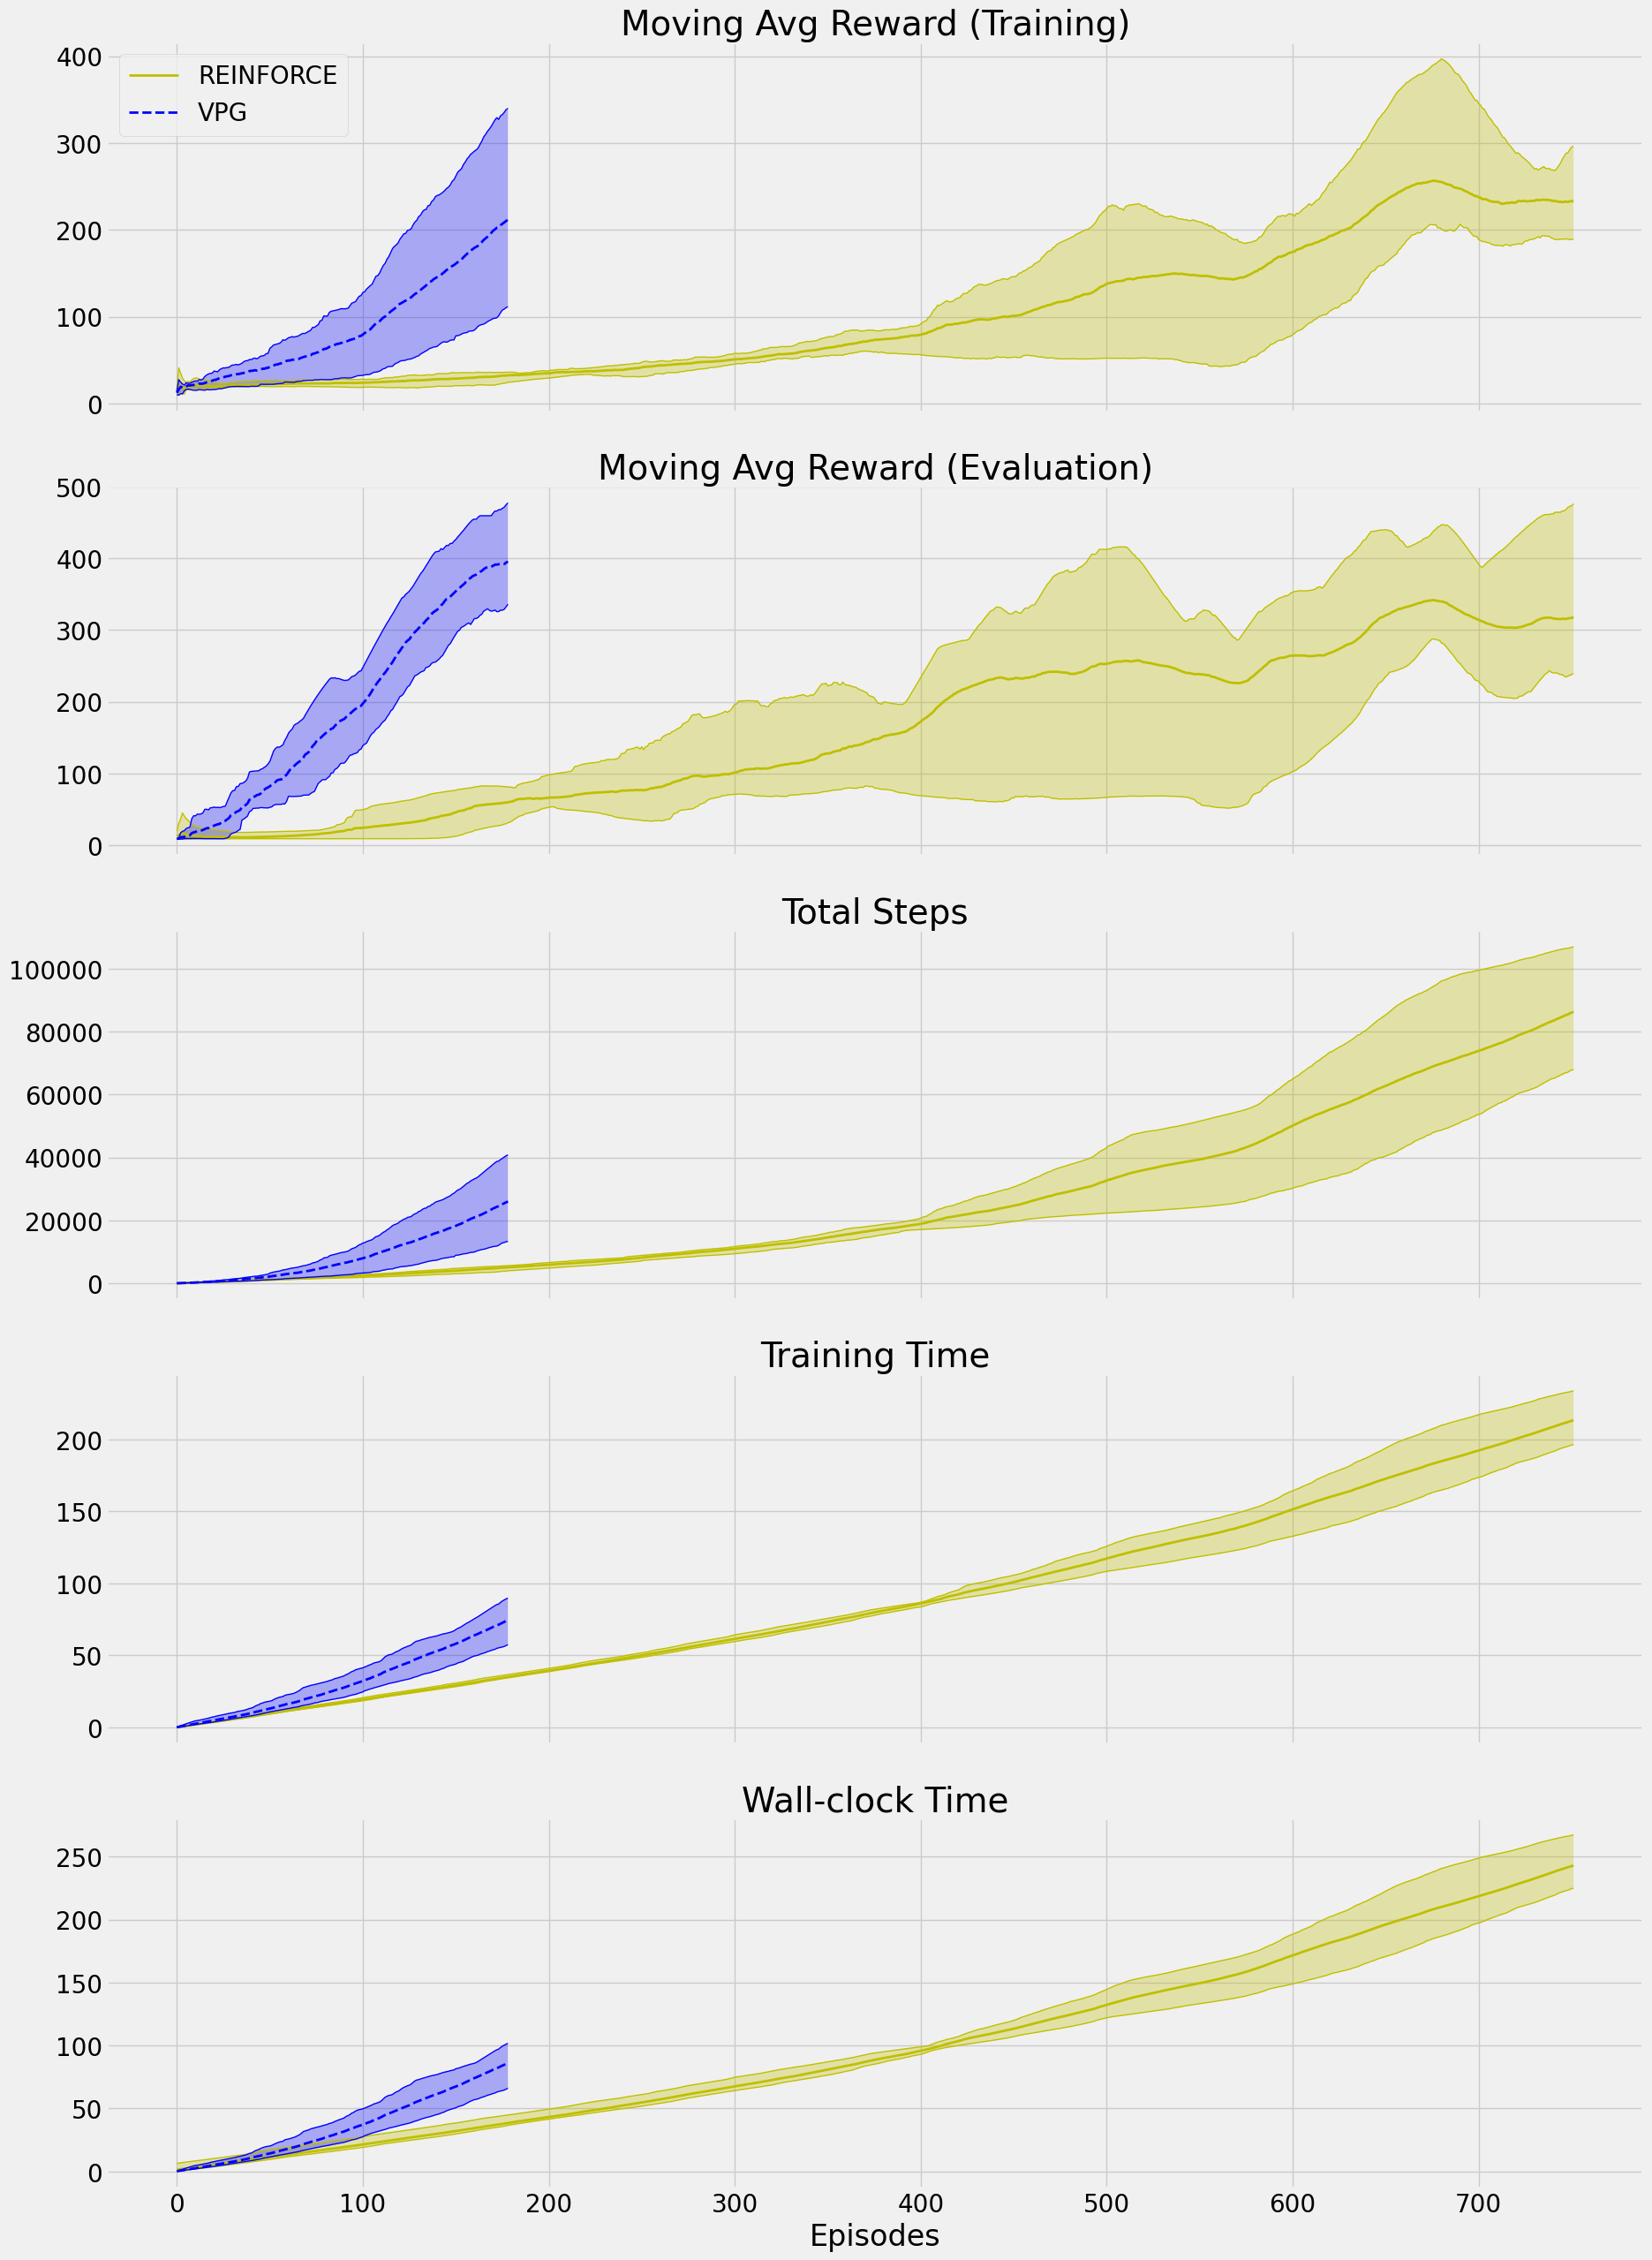

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# A3C
VPG is robust for simple problems. It uses MC returns without any bootstrapping. The only bias is because we use function approximation, which is inherently biased, but since the ANN is only a baseline used to reduce the variance of the actual return, there is very little bias introduced, if at all.

Often, to reduce variation, we add bias. An algo called **Acynchronous Advantage Actor-Critic** (A3C) further reduces bias:
1. it uses n-step returns with bootstrapping, to learn policy and value fn
2. it uses concurrent actors to generate a broad set of experience samples in parallel.

In A3C, we create multiple worker-learner, each having its own env, policy and V-fn neural netork weights, used for generating experiences.

After an experience batch is colllected, each worker updates the global policy and v-function model asynchronously, without coordination with other workers. Then they reload their copy of the models and keep at it.

In [ ]:
# these impl of optims have shared memory for te parameters.

class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        super(SharedAdam, self).__init__(
            params, lr=lr, betas=betas, eps=eps,
            weight_decay=weight_decay, amsgrad=amsgrad)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['shared_step'] = torch.zeros(1).share_memory_()
                state['exp_avg'] = torch.zeros_like(p.data).share_memory_()
                state['exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()
                if weight_decay:
                    state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
                if amsgrad:
                    state['max_exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                # self.state[p]['steps'] = self.state[p]['shared_step'].item()
                # self.state[p]['shared_step'] += 1
                state = self.state[p]
                state['steps']  = state['shared_step'].item()
                state['shared_step'] += 1
        super().step(closure)

class SharedRMSprop(torch.optim.RMSprop):
    def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0, centered=False):
        super(SharedRMSprop, self).__init__(
            params, lr=lr, alpha=alpha,
            eps=eps, weight_decay=weight_decay,
            momentum=momentum, centered=centered)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['shared_step'] = torch.zeros(1).share_memory_()
                state['square_avg'] = torch.zeros_like(p.data).share_memory_()
                if weight_decay:
                    state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
                if momentum > 0:
                    state['momentum_buffer'] = torch.zeros_like(p.data).share_memory_()
                if centered:
                    state['grad_avg'] = torch.zeros_like(p.data).share_memory_()

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                self.state[p]['steps'] = self.state[p]['shared_step'].item()
                self.state[p]['shared_step'] += 1
        super().step(closure)


## n-Step Bootstrapping estimates

In VPG we used the full returns for our Advantage estimates: $A(S_t,A_t;ϕ) = G_t-V(S_t;ϕ)$

Now we use n-step returns with bootstrapping:
$$A(S_t,A_t;ϕ) = R_t+γR_{t+1}+\ldots+γ^nR_{t+n}+γ^{n+1}V(S_{t+n+1};ϕ)-V(S_t;\phi)
$$

Use tha above Adv in the following:
$$L_π(θ) = -\dfrac{1}{N}\sum_{n=0}^{N}\left[\underbrace{A(S_t,A_t;ϕ)}_{\text{estimated}\\ \text{advantage}}\underbrace{\log π(A_t|S_t;θ)}_{\text{log prob of} \\ \text{action taken}}+\underbrace{βH(\pi(S_t;θ))}_{\text{weighted entropy}}\right]
$$

Also use the n-step return to improve the value-function estimate.
$$L_v(ϕ) = \dfrac{1}{N}\sum_{n=0}^{N}\left[\left( R_t+γR_{t+1}+\ldots+γ^nR_{t+n}+γ^{n+1}V(S_{t+n+1};ϕ)-V(S_t;\phi)\right)^2\right]
$$

In [ ]:
class A3C():
  def __init__(self,
               policy_model_fn, # basically use FCDAP
               policy_model_max_grad_norm, # for clipping gradients of NN params
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn, # basically use FCV
               value_model_max_grad_norm, # for clipping gradients of NN params
               value_optimizer_fn,
               value_optimizer_lr,
               entropy_loss_weight,
               max_n_steps,
               n_workers):
    self.policy_model_fn = policy_model_fn
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.entropy_loss_weight = entropy_loss_weight
    self.max_n_steps = max_n_steps
    self.n_workers = n_workers

  def optimize_model(self, logpas, entropies, rewards, values,
                     local_policy_model, local_value_model):
    # similar to VPG, but using input params instead of self.*
    T = len(rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t]*rewards[t:]) for t in range(T)])
    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    # logpas, entropies, values are lists of tensors, populated by interaction_step()
    logpas = torch.cat(logpas) # concatenate elements of the list into one list
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    # calc the value_error to use it to score the log-probs or the actions.
    value_error = returns - values # adv fn: G_t-V(S_t; phi)
    # we want to maximise the performance measure J, so put '-' in front
    policy_loss = -(discounts * value_error.detach() * logpas).mean()
    entropy_loss = -entropies.mean()
    loss = policy_loss + self.entropy_loss_weight * entropy_loss

    # back prop local model, update shared model, copy back to local model
    self.shared_policy_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(),
                                   self.policy_model_max_grad_norm)
    # iterating over all local and shared policy network parameters
    for param, shared_param in zip(local_policy_model.parameters(),
                                   self.shared_policy_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad # copy every gradient from the local to the shared model.
    self.shared_policy_optimizer.step()
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

    ## optimise the value-fn NN
    value_loss = value_error.pow(2).mul(0.5).mean()
    # back prop
    self.shared_value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(local_value_model.parameters(),
                                   self.value_model_max_grad_norm)
    for param, shared_param in zip(local_value_model.parameters(),
                                   self.shared_value_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad
    self.shared_value_optimizer.step()
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

  # static for concurrent workers can all
  @staticmethod
  def interaction_step(state, env, local_policy_model, local_value_model,
                       logpas, entropies, rewards, values):
    action, is_exploratory, logpa, entropy = local_policy_model.full_pass(state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

    logpas.append(logpa)
    entropies.append(entropy)
    rewards.append(reward)
    values.append(local_value_model(state))

    return new_state, reward, is_terminal, is_truncated, is_exploratory

  def work(self, rank):
    """
    work function that each worker loops around in.
    rand - is used as an ID for workers.
    """
    last_debug_time = float('-inf')
    self.stats['n_active_workers'].add_(1)

    # create unique seed per working to diversify experiences
    local_seed = self.seed + rank
    env = self.make_env_fn(**self.make_env_kargs, seed=local_seed)
    torch.manual_seed(local_seed) ; np.random.seed(local_seed) ; random.seed(local_seed)

    nS = env.observation_space.shape[0]
    nA = env.action_space.n

    # create local policy model and init its weights with shared model
    local_policy_model = self.policy_model_fn(nS, nA)
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
    # do the same with value model
    local_value_model = self.value_model_fn(nS)
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

    global_episode_idx = self.stats['episode'].add_(1).item() - 1
    # start training loop
    while not self.get_out_signal:
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      # we use n-step returns for training the policy and value functions
      n_steps_start = 0
      total_episode_rewards = 0
      total_episode_steps = 0
      total_episode_exploration = 0
      # collect rollout
      logpas, entropies, rewards, values = [], [], [], []

      for step in count(start=1): # starting from 1
        # collect a step of experience
        state, reward, is_terminal, is_truncated, is_exploratory = self.interaction_step(
            state, env, local_policy_model, local_value_model,
            logpas, entropies, rewards, values)

        total_episode_steps += 1
        total_episode_rewards += reward
        total_episode_exploration += int(is_exploratory)

        if is_terminal or step - n_steps_start == self.max_n_steps:
          is_failure = is_terminal and not is_truncated
          # value of next state
          next_value = 0 if is_failure else local_value_model(state).detach().item()
          # by appending next_value to rewards, the optimisation code from VPG
          # remains largely the same.
          rewards.append(next_value)

          self.optimize_model(logpas, entropies, rewards, values,
                              local_policy_model, local_value_model)
          logpas, entropies, rewards, values = [], [], [], []
          n_steps_start = step

        if is_terminal:
          gc.collect()
          break

      # save global stats
      episode_elapsed = time.time() - episode_start
      evaluation_score, _ = self.evaluate(local_policy_model, env)
      #print(f"worker {rank} saving checkpoints...")
      self.save_checkpoint(global_episode_idx, local_policy_model)

      self.stats['episode_elapsed'][global_episode_idx].add_(episode_elapsed)
      self.stats['episode_timestep'][global_episode_idx].add_(total_episode_steps)
      self.stats['episode_reward'][global_episode_idx].add_(total_episode_rewards)
      self.stats['episode_exploration'][global_episode_idx].add_(total_episode_exploration/total_episode_steps)
      self.stats['evaluation_scores'][global_episode_idx].add_(evaluation_score)

      mean_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].mean().item()
      mean_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].mean().item()
      mean_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].mean().item()
      mean_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].mean().item()
      std_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].std().item()
      std_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].std().item()
      std_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].std().item()
      std_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].std().item()
      if std_10_reward != std_10_reward: std_10_reward = 0
      if std_100_reward != std_100_reward: std_100_reward = 0
      if std_100_eval_score != std_100_eval_score: std_100_eval_score = 0
      if std_100_exp_rat != std_100_exp_rat: std_100_exp_rat = 0
      global_n_steps = self.stats['episode_timestep'][:global_episode_idx+1].sum().item()
      global_training_elapsed = self.stats['episode_elapsed'][:global_episode_idx+1].sum().item()
      wallclock_elapsed = time.time() - self.training_start

      self.stats['result'][global_episode_idx][0].add_(global_n_steps)
      self.stats['result'][global_episode_idx][1].add_(mean_100_reward)
      self.stats['result'][global_episode_idx][2].add_(mean_100_eval_score)
      self.stats['result'][global_episode_idx][3].add_(global_training_elapsed)
      self.stats['result'][global_episode_idx][4].add_(wallclock_elapsed)

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-self.training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, global_episode_idx, global_n_steps, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      if rank == 0:
        print(debug_message, end='\r', flush=True)
        if time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS:
          print(ERASE_LINE + debug_message, flush=True)
          last_debug_time = time.time()

      with self.get_out_lock:
        potential_next_global_episode_idx = self.stats['episode'].item()
        self.reached_goal_mean_reward.add_( mean_100_eval_score>=self.goal_mean_100_reward)
        self.reached_max_minutes.add_(time.time()-self.training_start >= self.max_minutes*60)
        self.reached_max_episodes.add_(potential_next_global_episode_idx >= self.max_episodes)
        if self.reached_max_episodes or \
          self.reached_max_minutes or \
          self.reached_goal_mean_reward:
          self.get_out_signal.add_(1)
          break
        # else go work on another episode
        global_episode_idx = self.stats['episode'].add_(1).item() - 1

    while rank == 0 and self.stats['n_active_workers'].item() > 1:
      pass

    if rank == 0:
      print(ERASE_LINE + debug_message)
      if self.reached_max_minutes: print(u'--> reached_max_minutes \u2715')
      if self.reached_max_episodes: print(u'--> reached_max_episodes \u2715')
      if self.reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')

    env.close(); del env
    self.stats['n_active_workers'].sub_(1)

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    nS, nA = env.observation_space.shape[0], env.action_space.n
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    self.stats = {}
    self.stats['episode'] = torch.zeros(1, dtype=torch.int).share_memory_()
    self.stats['result'] = torch.zeros([max_episodes, 5]).share_memory_()
    self.stats['evaluation_scores'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_reward'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_timestep'] = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
    self.stats['episode_exploration'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_elapsed'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['n_active_workers'] = torch.zeros(1, dtype=torch.int).share_memory_()

    self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
    self.shared_policy_optimizer = self.policy_optimizer_fn(self.shared_policy_model,
                                                            self.policy_optimizer_lr)
    self.shared_value_model = self.value_model_fn(nS).share_memory()
    self.shared_value_optimizer = self.value_optimizer_fn(self.shared_value_model,
                                                          self.value_optimizer_lr)

    self.get_out_lock = mp.Lock() # capital L
    self.get_out_signal = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_minutes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_episodes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_goal_mean_reward = torch.zeros(1, dtype=torch.int).share_memory_()
    self.training_start = time.time()

    # spawn the workers
    workers = [mp.Process(target=self.work, args=(rank,)) for rank in range(self.n_workers)]
    [w.start() for w in workers]
    [w.join() for w in workers]
    wallclock_time = time.time() - self.training_start

    final_eval_score, score_std = self.evaluate(self.shared_policy_model, env, n_episodes=100)
    env.close(); del env

    final_episode = self.stats['episode'].item()
    training_time = self.stats['episode_elapsed'][:final_episode+1].sum().item()

    print('Training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
          ' {:.2f}s wall-clock time.\n'.format(
              final_eval_score, score_std, training_time, wallclock_time))

    self.stats['result'] = self.stats['result'].numpy()
    self.stats['result'][final_episode:, ...] = np.nan
    self.get_cleaned_checkpoints()
    return self.stats['result'], final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    #print(f'checkpoint_dir {self.checkpoint_dir}')
    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))

    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.shared_policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.shared_policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    #print(f"save_checkpoint {episode_idx} !!!!!!!!!!!!!!!!")
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


## Train A3C

In [ ]:
a3c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 10,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
  policy_optimizer_lr = 0.0005

  value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 0.0007

  entropy_loss_weight = 0.001

  max_n_steps = 50
  n_workers = 8

  env_name, gamma, max_minutes, \
  max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = A3C(policy_model_fn,
              policy_model_max_grad_norm,
              policy_optimizer_fn,
              policy_optimizer_lr,
              value_model_fn,
              value_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              entropy_loss_weight,
              max_n_steps,
              n_workers)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallclock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
  a3c_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent
a3c_results = np.array(a3c_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

el 00:00:01, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.5±0.0, ev 020.0±000.0
el 00:01:02, ep 0267, ts 010182, ar 10 084.8±044.6, 100 054.2±038.1, ex 100 0.4±0.1, ev 116.7±068.5
el 00:02:03, ep 0402, ts 031270, ar 10 197.2±092.5, 100 183.6±109.1, ex 100 0.3±0.0, ev 296.8±123.9
el 00:03:10, ep 0506, ts 055743, ar 10 323.7±169.7, 100 237.4±116.0, ex 100 0.3±0.0, ev 287.3±128.5
el 00:04:18, ep 0586, ts 085679, ar 10 430.6±156.9, 100 361.1±126.2, ex 100 0.2±0.0, ev 421.1±111.5
el 00:05:21, ep 0650, ts 113522, ar 10 500.0±000.0, 100 422.6±110.2, ex 100 0.2±0.0, ev 445.3±102.8
el 00:06:23, ep 0723, ts 143107, ar 10 500.0±000.0, 100 430.9±105.9, ex 100 0.2±0.0, ev 441.8±098.9
el 00:07:19, ep 0779, ts 169072, ar 10 466.3±060.6, 100 470.1±060.7, ex 100 0.2±0.0, ev 481.5±049.8
--> reach_goal_mean_reward ✓


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Training complete.
Final evaluation score 500.00±0.00 in 3149.01s training time, 440.54s wall-clock time.

el 00:00:01, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 011.0±000.0
el 00:01:03, ep 0278, ts 008783, ar 10 069.8±020.9, 100 039.8±022.5, ex 100 0.4±0.1, ev 107.2±114.6
el 00:02:03, ep 0442, ts 023183, ar 10 176.1±069.3, 100 109.8±064.1, ex 100 0.4±0.0, ev 419.4±113.1
el 00:03:07, ep 0551, ts 047799, ar 10 204.5±047.3, 100 230.2±085.8, ex 100 0.3±0.0, ev 330.3±117.7
el 00:04:13, ep 0625, ts 070853, ar 10 445.4±082.4, 100 297.6±123.4, ex 100 0.3±0.0, ev 361.6±143.4
el 00:05:19, ep 0692, ts 101205, ar 10 474.1±081.9, 100 435.6±096.9, ex 100 0.3±0.0, ev 475.5±065.0
el 00:05:19, ep 0692, ts 101205, ar 10 474.1±081.9, 100 435.6±096.9, ex 100 0.3±0.0, ev 475.5±065.0
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 2284.04s training time, 326.45s wall-clock time.

el 00:00:02, ep 0000, ts 000013, ar 10 013.0±000.0, 100 0

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will


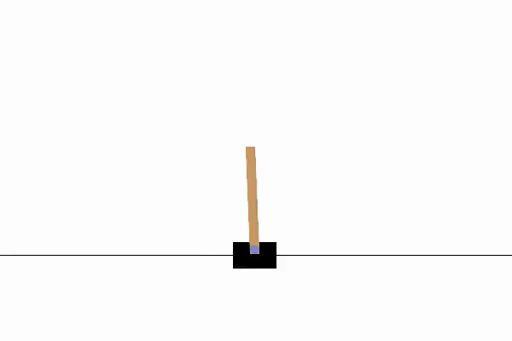
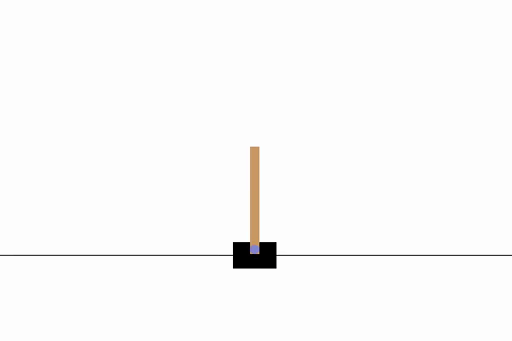

In [ ]:
best_agent.demo_progression()

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecate


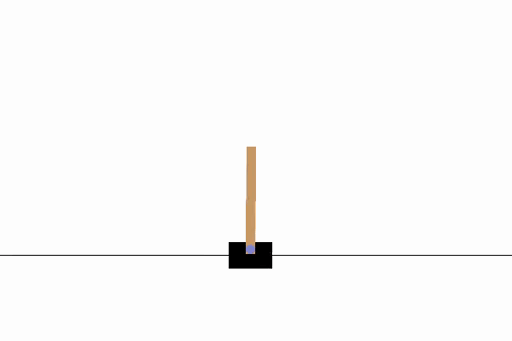
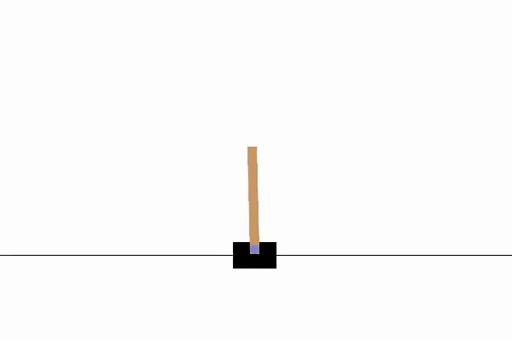

In [ ]:
best_agent.demo_last()

In [ ]:
a3c_max_t, a3c_max_r, a3c_max_s, a3c_max_sec, a3c_max_rt = np.max(a3c_results, axis=0).T
a3c_min_t, a3c_min_r, a3c_min_s, a3c_min_sec, a3c_min_rt = np.min(a3c_results, axis=0).T
a3c_mean_t, a3c_mean_r, a3c_mean_s, a3c_mean_sec, a3c_mean_rt = np.mean(a3c_results, axis=0).T
a3c_x = np.arange(np.max((len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [ ]:
a3c_root_dir = os.path.join(RESULTS_DIR, 'a3c')
not os.path.exists(a3c_root_dir) and os.makedirs(a3c_root_dir)

np.save(os.path.join(a3c_root_dir, 'x'), a3c_x)

np.save(os.path.join(a3c_root_dir, 'max_r'), a3c_max_r)
np.save(os.path.join(a3c_root_dir, 'min_r'), a3c_min_r)
np.save(os.path.join(a3c_root_dir, 'mean_r'), a3c_mean_r)

np.save(os.path.join(a3c_root_dir, 'max_s'), a3c_max_s)
np.save(os.path.join(a3c_root_dir, 'min_s'), a3c_min_s )
np.save(os.path.join(a3c_root_dir, 'mean_s'), a3c_mean_s)

np.save(os.path.join(a3c_root_dir, 'max_t'), a3c_max_t)
np.save(os.path.join(a3c_root_dir, 'min_t'), a3c_min_t)
np.save(os.path.join(a3c_root_dir, 'mean_t'), a3c_mean_t)

np.save(os.path.join(a3c_root_dir, 'max_sec'), a3c_max_sec)
np.save(os.path.join(a3c_root_dir, 'min_sec'), a3c_min_sec)
np.save(os.path.join(a3c_root_dir, 'mean_sec'), a3c_mean_sec)

np.save(os.path.join(a3c_root_dir, 'max_rt'), a3c_max_rt)
np.save(os.path.join(a3c_root_dir, 'min_rt'), a3c_min_rt)
np.save(os.path.join(a3c_root_dir, 'mean_rt'), a3c_mean_rt)

## load from files

In [ ]:
!rm -f results/a3c/*
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_r.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_rt.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_s.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_sec.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_t.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_r.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_rt.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_s.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_sec.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_t.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_r.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_rt.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_s.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_sec.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_t.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/x.npy

2025-01-05 00:18:02 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_r.npy [40128/40128] -> "results/a3c/max_r.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_rt.npy [40128/40128] -> "results/a3c/max_rt.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_s.npy [40128/40128] -> "results/a3c/max_s.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_sec.npy [40128/40128] -> "results/a3c/max_sec.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_t.npy [40128/40128] -> "results/a3c/max_t.npy" [1]
2025-01-05 00:18:04 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_r.npy [40128/40128] -> "results/a3c/mean_r.npy" [1]
2025-01-05 00:18:04 URL:https://raw.githubusercontent.com/rome

In [ ]:
a3c_root_dir = os.path.join(RESULTS_DIR, 'a3c')

a3c_x = np.load(os.path.join(a3c_root_dir, 'x.npy'))

a3c_max_r = np.load(os.path.join(a3c_root_dir, 'max_r.npy'))
a3c_min_r = np.load(os.path.join(a3c_root_dir, 'min_r.npy'))
a3c_mean_r = np.load(os.path.join(a3c_root_dir, 'mean_r.npy'))

a3c_max_s = np.load(os.path.join(a3c_root_dir, 'max_s.npy'))
a3c_min_s = np.load(os.path.join(a3c_root_dir, 'min_s.npy'))
a3c_mean_s = np.load(os.path.join(a3c_root_dir, 'mean_s.npy'))

a3c_max_t = np.load(os.path.join(a3c_root_dir, 'max_t.npy'))
a3c_min_t = np.load(os.path.join(a3c_root_dir, 'min_t.npy'))
a3c_mean_t = np.load(os.path.join(a3c_root_dir, 'mean_t.npy'))

a3c_max_sec = np.load(os.path.join(a3c_root_dir, 'max_sec.npy'))
a3c_min_sec = np.load(os.path.join(a3c_root_dir, 'min_sec.npy'))
a3c_mean_sec = np.load(os.path.join(a3c_root_dir, 'mean_sec.npy'))

a3c_max_rt = np.load(os.path.join(a3c_root_dir, 'max_rt.npy'))
a3c_min_rt = np.load(os.path.join(a3c_root_dir, 'min_rt.npy'))
a3c_mean_rt = np.load(os.path.join(a3c_root_dir, 'mean_rt.npy'))

## plotting A3C

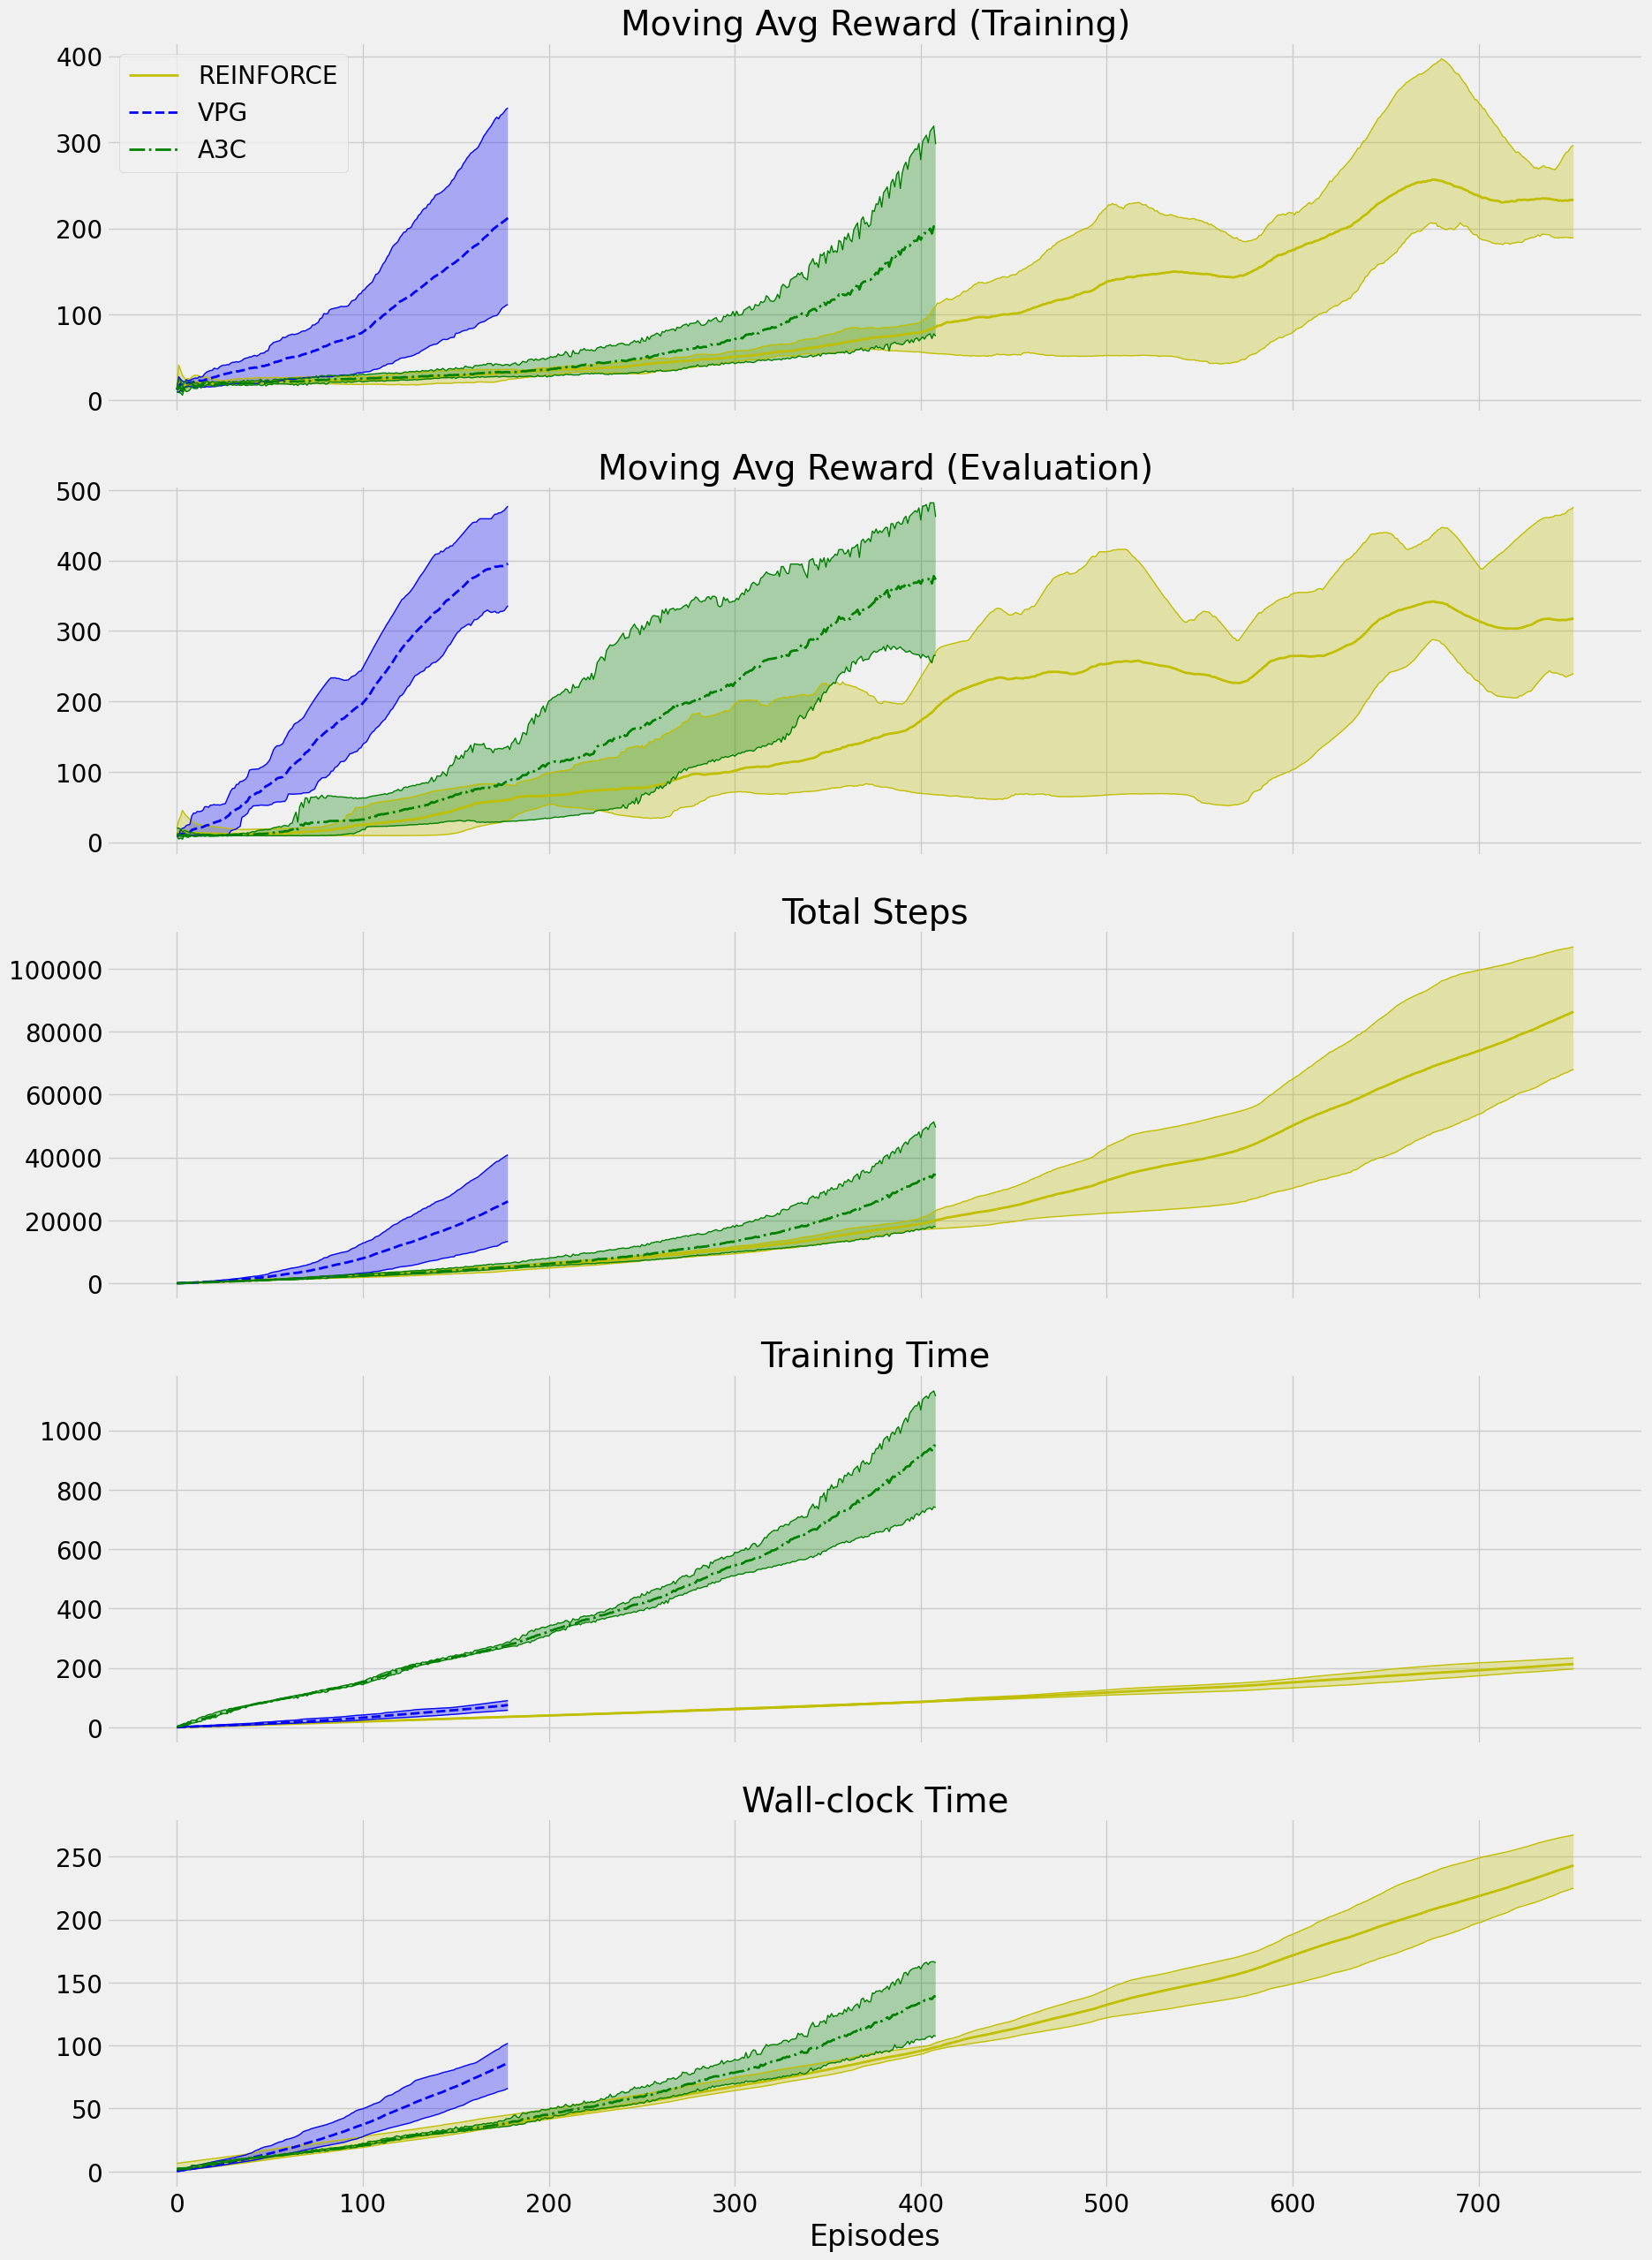

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# GAE

**Generalised Advantage Estimation** (GAE) combines multiple n-step bootstrapping targets in a single target, which is more robust. It's analagous to the λ-target in TD(λ), but for advantages.

In policy-gradient and actor-critic methods, we try to estimate the gradient of the following form:
$$g = \mathbb E\left[\sum_{t=0}^{∞}\psi_t\nabla_θ \log π(A_t|S_t;θ)\right]
$$

We can replace Ψ for a number of rexpressions that estimate the score with different levels of variance and bias:
* this is the total return starting from step 0, to the end: $\psi_t=\sum_{t=0}^{T}γ^tR_t$
* but as in REINFORCE, we can start at the current timestep and go to the end of the episode:  $\psi_t=\sum_{t'=t}^{T}γ^{t'-t}R_{t'}$
* as in VPG, we can use a baseline, which in our case was the state-value function: $\psi_t=\sum_{t'=t}^{T}γ^{t'-t}R_{t'}-b(S_t)$
* In A3C, we used the n-step adv estimate, which is the lowest variance (really?): $ψ_t=a_π(S_t,A_t)$
* but we could also use the true action-value function:  $ψ_t=q_π(S_t,A_t)$
* or even the TD residual, which can be seen as a one-step adv est.: $\psi_t = R_t+v_\pi(S_{t+1})-v_\pi(S_t)$

N-step advantage estimates:
* 1-step: $A^1(S_t,A_t;\phi)=R_t+\gamma V(S_{t+1};\phi)-V(S_t;\phi)$
* 2-step: $A^2(S_t,A_t;\phi)=R_t+\gamma R_{t+1}+\gamma^2 V(S_{t+2};\phi)-V(S_t;\phi)$
* 3-step: $A^3(S_t,A_t;\phi)=R_t+\gamma R_{t+1}+\gamma^2R_{t+2}+\gamma^3 V(S_{t+3};\phi)-V(S_t;\phi)$
* $\ldots$
* n-step: $A^n(S_t,A_t;\phi)=R_t+\gamma R_{t+1}+\gamma^2R_{t+2}+\gamma^n V(S_{t+n};\phi)-V(S_t;\phi)$

which we can mix to make an estimate analogous to TD-λ but for advantages:
$$A^{GAE(\gamma,\lambda)}(S_t,A_t;\phi)=\sum_{l=0}^{∞}(\gamma\lambda)^l\delta_{t+l}
$$
similarly, when λ=0, it returns the 1-step adv est: $A^{GAE(\gamma,0)}(S_t,A_t;\phi)=R_t+\gamma V(S_{t+1};\phi)-V(S_t;\phi)$

and when λ=1, it returns the infinite-step adv est: $A^{GAE(\gamma,1)}(S_t,A_t;\phi)=\sum_{l=0}^{\infty}\gamma^lR_{t+l}-V(S_t;\phi)$

We can use several different targets to train the state-value function neural network used to calculate GAE values:
* we could use the reward to go, aka Monte-Carlo returns: $y_t=\sum_{t'=t}^{T}\gamma^{t'-t}R_{t'}$
* the n-step bootstrapping target, incl the TD target: $y_t=R_t+\gamma R_{t+1}+\ldots+\gamma^nR_{t+n}+\gamma^{n+1}V(S_{t+n+1};\phi)$
* or the GAE, as a TD(λ) estimate: $y_t=A^{GAE(\gamma,\lambda)}(S_t,A_t;\phi)+V(S_t;\phi)$

In [ ]:
class GAE():
  def __init__(self,
               policy_model_fn, # basically use FCDAP
               policy_model_max_grad_norm, # for clipping gradients of NN params
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn, # basically use FCV
               value_model_max_grad_norm, # for clipping gradients of NN params
               value_optimizer_fn,
               value_optimizer_lr,
               entropy_loss_weight,
               max_n_steps,
               n_workers,
               tau): # tau is lambda, use tau s.t. not clash with python keyword
    self.policy_model_fn = policy_model_fn
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.entropy_loss_weight = entropy_loss_weight
    self.max_n_steps = max_n_steps
    self.n_workers = n_workers
    self.tau = tau

  def optimize_model(self, logpas, entropies, rewards, values,
                     local_policy_model, local_value_model):
    # similar to VPG, but using input params instead of self.*
    T = len(rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t]*rewards[t:]) for t in range(T)])

    # logpas, entropies, values are lists of tensors, populated by interaction_step()
    logpas = torch.cat(logpas) # concatenate elements of the list into one list
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    # create ny.array with all the state values,
    np_values = values.view(-1).data.numpy()
    # an array with the (gamma * lambda)^l. BTW, lambda is AKA tau, so we use tau here
    tau_discounts = np.logspace(0, T-1, num=T-1, base=self.gamma*self.tau, endpoint=False)
    # array of TD errors: R_t+gamma*value_t+1 - value_t, for t=0 to T
    advs = rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]
    # GAEs=tau_discounts * TD_errors
    gaes = np.array([np.sum(tau_discounts[:T-1-t] * advs[t:]) for t in range(T-1)])

    values = values[:-1,...]
    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    gaes = torch.FloatTensor(gaes).unsqueeze(1)

    # we use gaes to calculate policy loss (instead of value_error as in A3C)
    policy_loss = -(discounts * gaes.detach() * logpas).mean()
    entropy_loss = -entropies.mean()
    loss = policy_loss + self.entropy_loss_weight * entropy_loss

    # back prop local model, update shared model, copy back to local model
    self.shared_policy_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(),
                                   self.policy_model_max_grad_norm)
    # iterating over all local and shared policy network parameters
    for param, shared_param in zip(local_policy_model.parameters(),
                                   self.shared_policy_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad # copy every gradient from the local to the shared model.
    self.shared_policy_optimizer.step()
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

    ## optimise the value-fn NN
    value_error = returns - values
    value_loss = value_error.pow(2).mul(0.5).mean()
    # back prop
    self.shared_value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(local_value_model.parameters(),
                                   self.value_model_max_grad_norm)
    for param, shared_param in zip(local_value_model.parameters(),
                                   self.shared_value_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad
    self.shared_value_optimizer.step()
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

  # same as A3C
  @staticmethod
  def interaction_step(state, env, local_policy_model, local_value_model,
                       logpas, entropies, rewards, values):
    action, is_exploratory, logpa, entropy = local_policy_model.full_pass(state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

    logpas.append(logpa)
    entropies.append(entropy)
    rewards.append(reward)
    values.append(local_value_model(state))

    return new_state, reward, is_terminal, is_truncated, is_exploratory

  def work(self, rank):
    """
    work function that each worker loops around in.
    rand - is used as an ID for workers.
    """
    last_debug_time = float('-inf')
    self.stats['n_active_workers'].add_(1)

    # create unique seed per working to diversify experiences
    local_seed = self.seed + rank
    env = self.make_env_fn(**self.make_env_kargs, seed=local_seed)
    torch.manual_seed(local_seed) ; np.random.seed(local_seed) ; random.seed(local_seed)

    nS = env.observation_space.shape[0]
    nA = env.action_space.n

    # create local policy model and init its weights with shared model
    local_policy_model = self.policy_model_fn(nS, nA)
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
    # do the same with value model
    local_value_model = self.value_model_fn(nS)
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

    global_episode_idx = self.stats['episode'].add_(1).item() - 1
    # start training loop
    while not self.get_out_signal:
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      # we use n-step returns for training the policy and value functions
      n_steps_start = 0
      total_episode_rewards = 0
      total_episode_steps = 0
      total_episode_exploration = 0
      # collect rollout
      logpas, entropies, rewards, values = [], [], [], []

      for step in count(start=1): # starting from 1
        # collect a step of experience
        state, reward, is_terminal, is_truncated, is_exploratory = self.interaction_step(
            state, env, local_policy_model, local_value_model,
            logpas, entropies, rewards, values)

        total_episode_steps += 1
        total_episode_rewards += reward
        total_episode_exploration += int(is_exploratory)

        if is_terminal or step - n_steps_start == self.max_n_steps:
          is_failure = is_terminal and not is_truncated
          # value of next state
          next_value = 0 if is_failure else local_value_model(state).detach().item()
          # by appending next_value to rewards, the optimisation code from VPG
          # remains largely the same.
          rewards.append(next_value)
          values.append(torch.FloatTensor([[next_value,],])) # extra to A3C

          self.optimize_model(logpas, entropies, rewards, values,
                              local_policy_model, local_value_model)
          logpas, entropies, rewards, values = [], [], [], []
          n_steps_start = step

        if is_terminal:
          gc.collect()
          break

      # save global stats
      episode_elapsed = time.time() - episode_start
      evaluation_score, _ = self.evaluate(local_policy_model, env)
      self.save_checkpoint(global_episode_idx, local_policy_model)

      self.stats['episode_elapsed'][global_episode_idx].add_(episode_elapsed)
      self.stats['episode_timestep'][global_episode_idx].add_(total_episode_steps)
      self.stats['episode_reward'][global_episode_idx].add_(total_episode_rewards)
      self.stats['episode_exploration'][global_episode_idx].add_(total_episode_exploration/total_episode_steps)
      self.stats['evaluation_scores'][global_episode_idx].add_(evaluation_score)

      mean_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].mean().item()
      mean_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].mean().item()
      mean_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].mean().item()
      mean_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].mean().item()
      std_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].std().item()
      std_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].std().item()
      std_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].std().item()
      std_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].std().item()
      if std_10_reward != std_10_reward: std_10_reward = 0
      if std_100_reward != std_100_reward: std_100_reward = 0
      if std_100_eval_score != std_100_eval_score: std_100_eval_score = 0
      if std_100_exp_rat != std_100_exp_rat: std_100_exp_rat = 0
      global_n_steps = self.stats['episode_timestep'][:global_episode_idx+1].sum().item()
      global_training_elapsed = self.stats['episode_elapsed'][:global_episode_idx+1].sum().item()
      wallclock_elapsed = time.time() - self.training_start

      self.stats['result'][global_episode_idx][0].add_(global_n_steps)
      self.stats['result'][global_episode_idx][1].add_(mean_100_reward)
      self.stats['result'][global_episode_idx][2].add_(mean_100_eval_score)
      self.stats['result'][global_episode_idx][3].add_(global_training_elapsed)
      self.stats['result'][global_episode_idx][4].add_(wallclock_elapsed)

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-self.training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, global_episode_idx, global_n_steps, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      if rank == 0:
        print(debug_message, end='\r', flush=True)
        if time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS:
          print(ERASE_LINE + debug_message, flush=True)
          last_debug_time = time.time()

      with self.get_out_lock:
        potential_next_global_episode_idx = self.stats['episode'].item()
        self.reached_goal_mean_reward.add_( mean_100_eval_score>=self.goal_mean_100_reward)
        self.reached_max_minutes.add_(time.time()-self.training_start >= self.max_minutes*60)
        self.reached_max_episodes.add_(potential_next_global_episode_idx >= self.max_episodes)
        if self.reached_max_episodes or \
          self.reached_max_minutes or \
          self.reached_goal_mean_reward:
          self.get_out_signal.add_(1)
          break
        # else go work on another episode
        global_episode_idx = self.stats['episode'].add_(1).item() - 1

    while rank == 0 and self.stats['n_active_workers'].item() > 1:
      pass

    if rank == 0:
      print(ERASE_LINE + debug_message)
      if self.reached_max_minutes: print(u'--> reached_max_minutes \u2715')
      if self.reached_max_episodes: print(u'--> reached_max_episodes \u2715')
      if self.reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')

    env.close(); del env
    self.stats['n_active_workers'].sub_(1)

  ## the rest are the same as A3C
  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    nS, nA = env.observation_space.shape[0], env.action_space.n
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    self.stats = {}
    self.stats['episode'] = torch.zeros(1, dtype=torch.int).share_memory_()
    self.stats['result'] = torch.zeros([max_episodes, 5]).share_memory_()
    self.stats['evaluation_scores'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_reward'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_timestep'] = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
    self.stats['episode_exploration'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_elapsed'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['n_active_workers'] = torch.zeros(1, dtype=torch.int).share_memory_()

    self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
    self.shared_policy_optimizer = self.policy_optimizer_fn(self.shared_policy_model,
                                                            self.policy_optimizer_lr)
    self.shared_value_model = self.value_model_fn(nS).share_memory()
    self.shared_value_optimizer = self.value_optimizer_fn(self.shared_value_model,
                                                          self.value_optimizer_lr)

    self.get_out_lock = mp.Lock() # capital L
    self.get_out_signal = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_minutes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_episodes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_goal_mean_reward = torch.zeros(1, dtype=torch.int).share_memory_()
    self.training_start = time.time()

    # spawn the workers
    workers = [mp.Process(target=self.work, args=(rank,)) for rank in range(self.n_workers)]
    [w.start() for w in workers]
    [w.join() for w in workers]
    wallclock_time = time.time() - self.training_start

    final_eval_score, score_std = self.evaluate(self.shared_policy_model, env, n_episodes=100)
    env.close(); del env

    final_episode = self.stats['episode'].item()
    training_time = self.stats['episode_elapsed'][:final_episode+1].sum().item()

    print('Training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
          ' {:.2f}s wall-clock time.\n'.format(
              final_eval_score, score_std, training_time, wallclock_time))

    self.stats['result'] = self.stats['result'].numpy()
    self.stats['result'][final_episode:, ...] = np.nan
    self.get_cleaned_checkpoints()
    return self.stats['result'], final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    #print(f'checkpoint_dir {self.checkpoint_dir}')
    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))

    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int64)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.shared_policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.shared_policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    #print(f"save_checkpoint {episode_idx} !!!!!!!!!!!!!!!!")
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))



## Train GAE

In [ ]:
gae_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 0.99,
      'max_minutes': 10,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
  policy_optimizer_lr = 4e-4

  value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 9e-4

  entropy_loss_weight = 0.001

  max_n_steps = 50
  n_workers = 6
  tau = 0.95

  env_name, gamma, max_minutes, \
  max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = GAE(policy_model_fn,
              policy_model_max_grad_norm,
              policy_optimizer_fn,
              policy_optimizer_lr,
              value_model_fn,
              value_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              entropy_loss_weight,
              max_n_steps,
              n_workers,
              tau)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallclock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
  gae_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent
gae_results = np.array(gae_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

el 00:00:01, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.5±0.0, ev 009.0±000.0
el 00:01:02, ep 0343, ts 014291, ar 10 047.8±009.7, 100 058.0±034.2, ex 100 0.1±0.0, ev 056.9±029.5
el 00:02:02, ep 0648, ts 032343, ar 10 056.3±011.5, 100 059.4±025.4, ex 100 0.1±0.0, ev 055.4±018.6
el 00:03:03, ep 0962, ts 050010, ar 10 044.2±009.7, 100 047.9±021.1, ex 100 0.0±0.0, ev 045.8±018.4
el 00:04:03, ep 1318, ts 061799, ar 10 039.7±018.7, 100 040.3±012.9, ex 100 0.0±0.0, ev 042.3±013.9
el 00:05:03, ep 1628, ts 077398, ar 10 044.8±022.7, 100 051.2±017.6, ex 100 0.0±0.0, ev 056.3±022.5
el 00:06:05, ep 1929, ts 094775, ar 10 038.0±008.4, 100 055.5±031.3, ex 100 0.0±0.0, ev 054.3±025.2
el 00:07:06, ep 2225, ts 111993, ar 10 059.1±010.8, 100 059.2±015.0, ex 100 0.0±0.0, ev 062.0±018.8
el 00:08:07, ep 2499, ts 130064, ar 10 073.4±057.9, 100 076.1±033.7, ex 100 0.0±0.0, ev 075.0±030.0
el 00:09:08, ep 2769, ts 150383, ar 10 068.5±016.1, 100 080.6±031.9, ex 100 0.0±0.0, ev 077.0±032.4


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Training complete.
Final evaluation score 58.73±20.00 in 3412.29s training time, 600.75s wall-clock time.

el 00:00:01, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 011.0±000.0
el 00:01:02, ep 0319, ts 013446, ar 10 045.5±039.6, 100 061.8±041.2, ex 100 0.4±0.1, ev 121.6±063.8
el 00:02:05, ep 0450, ts 040711, ar 10 277.1±094.8, 100 229.3±109.6, ex 100 0.3±0.0, ev 359.4±130.6
el 00:03:06, ep 0532, ts 075059, ar 10 500.0±000.0, 100 391.5±120.9, ex 100 0.2±0.0, ev 454.3±085.7
el 00:03:21, ep 0550, ts 083737, ar 10 468.4±054.6, 100 430.3±102.0, ex 100 0.2±0.0, ev 477.3±061.4
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 1101.13s training time, 203.34s wall-clock time.

el 00:00:02, ep 0000, ts 000013, ar 10 013.0±000.0, 100 013.0±000.0, ex 100 0.2±0.0, ev 010.0±000.0
el 00:01:03, ep 0259, ts 010686, ar 10 099.4±058.4, 100 068.8±050.2, ex 100 0.4±0.1, ev 235.9±174.4
el 00:02:05, ep 0383, ts 039171, ar 10 242.5±046.7, 100 2

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: http


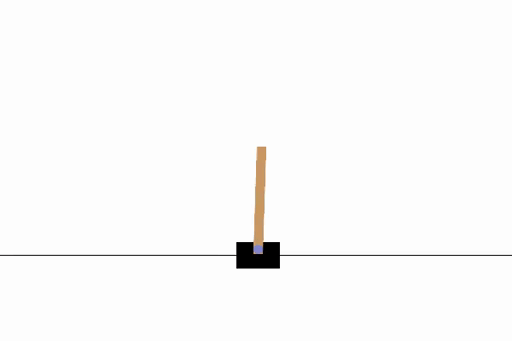
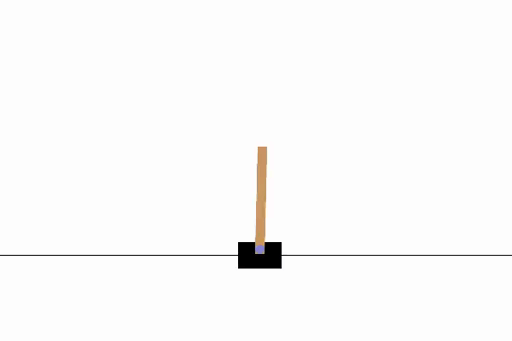

In [ ]:
best_agent.demo_progression()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



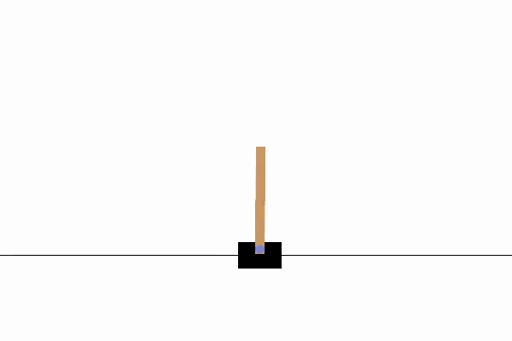
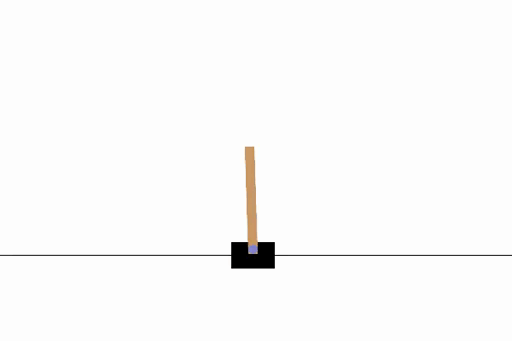

In [ ]:
best_agent.demo_last()

In [ ]:
gae_max_t, gae_max_r, gae_max_s, gae_max_sec, gae_max_rt = np.max(gae_results, axis=0).T
gae_min_t, gae_min_r, gae_min_s, gae_min_sec, gae_min_rt = np.min(gae_results, axis=0).T
gae_mean_t, gae_mean_r, gae_mean_s, gae_mean_sec, gae_mean_rt = np.mean(gae_results, axis=0).T
gae_x = np.arange(np.max(
    (len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [ ]:
gae_root_dir = os.path.join(RESULTS_DIR, 'gae')
not os.path.exists(gae_root_dir) and os.makedirs(gae_root_dir)

np.save(os.path.join(gae_root_dir, 'x'), gae_x)

np.save(os.path.join(gae_root_dir, 'max_r'), gae_max_r)
np.save(os.path.join(gae_root_dir, 'min_r'), gae_min_r)
np.save(os.path.join(gae_root_dir, 'mean_r'), gae_mean_r)

np.save(os.path.join(gae_root_dir, 'max_s'), gae_max_s)
np.save(os.path.join(gae_root_dir, 'min_s'), gae_min_s )
np.save(os.path.join(gae_root_dir, 'mean_s'), gae_mean_s)

np.save(os.path.join(gae_root_dir, 'max_t'), gae_max_t)
np.save(os.path.join(gae_root_dir, 'min_t'), gae_min_t)
np.save(os.path.join(gae_root_dir, 'mean_t'), gae_mean_t)

np.save(os.path.join(gae_root_dir, 'max_sec'), gae_max_sec)
np.save(os.path.join(gae_root_dir, 'min_sec'), gae_min_sec)
np.save(os.path.join(gae_root_dir, 'mean_sec'), gae_mean_sec)

np.save(os.path.join(gae_root_dir, 'max_rt'), gae_max_rt)
np.save(os.path.join(gae_root_dir, 'min_rt'), gae_min_rt)
np.save(os.path.join(gae_root_dir, 'mean_rt'), gae_mean_rt)

## load from files

In [ ]:
!rm -f results/gae/*
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/x.npy

In [ ]:
gae_root_dir = os.path.join(RESULTS_DIR, 'gae')

gae_x = np.load(os.path.join(gae_root_dir, 'x.npy'))

gae_max_r = np.load(os.path.join(gae_root_dir, 'max_r.npy'))
gae_min_r = np.load(os.path.join(gae_root_dir, 'min_r.npy'))
gae_mean_r = np.load(os.path.join(gae_root_dir, 'mean_r.npy'))

gae_max_s = np.load(os.path.join(gae_root_dir, 'max_s.npy'))
gae_min_s = np.load(os.path.join(gae_root_dir, 'min_s.npy'))
gae_mean_s = np.load(os.path.join(gae_root_dir, 'mean_s.npy'))

gae_max_t = np.load(os.path.join(gae_root_dir, 'max_t.npy'))
gae_min_t = np.load(os.path.join(gae_root_dir, 'min_t.npy'))
gae_mean_t = np.load(os.path.join(gae_root_dir, 'mean_t.npy'))

gae_max_sec = np.load(os.path.join(gae_root_dir, 'max_sec.npy'))
gae_min_sec = np.load(os.path.join(gae_root_dir, 'min_sec.npy'))
gae_mean_sec = np.load(os.path.join(gae_root_dir, 'mean_sec.npy'))

gae_max_rt = np.load(os.path.join(gae_root_dir, 'max_rt.npy'))
gae_min_rt = np.load(os.path.join(gae_root_dir, 'min_rt.npy'))
gae_mean_rt = np.load(os.path.join(gae_root_dir, 'mean_rt.npy'))

## Plotting GAE

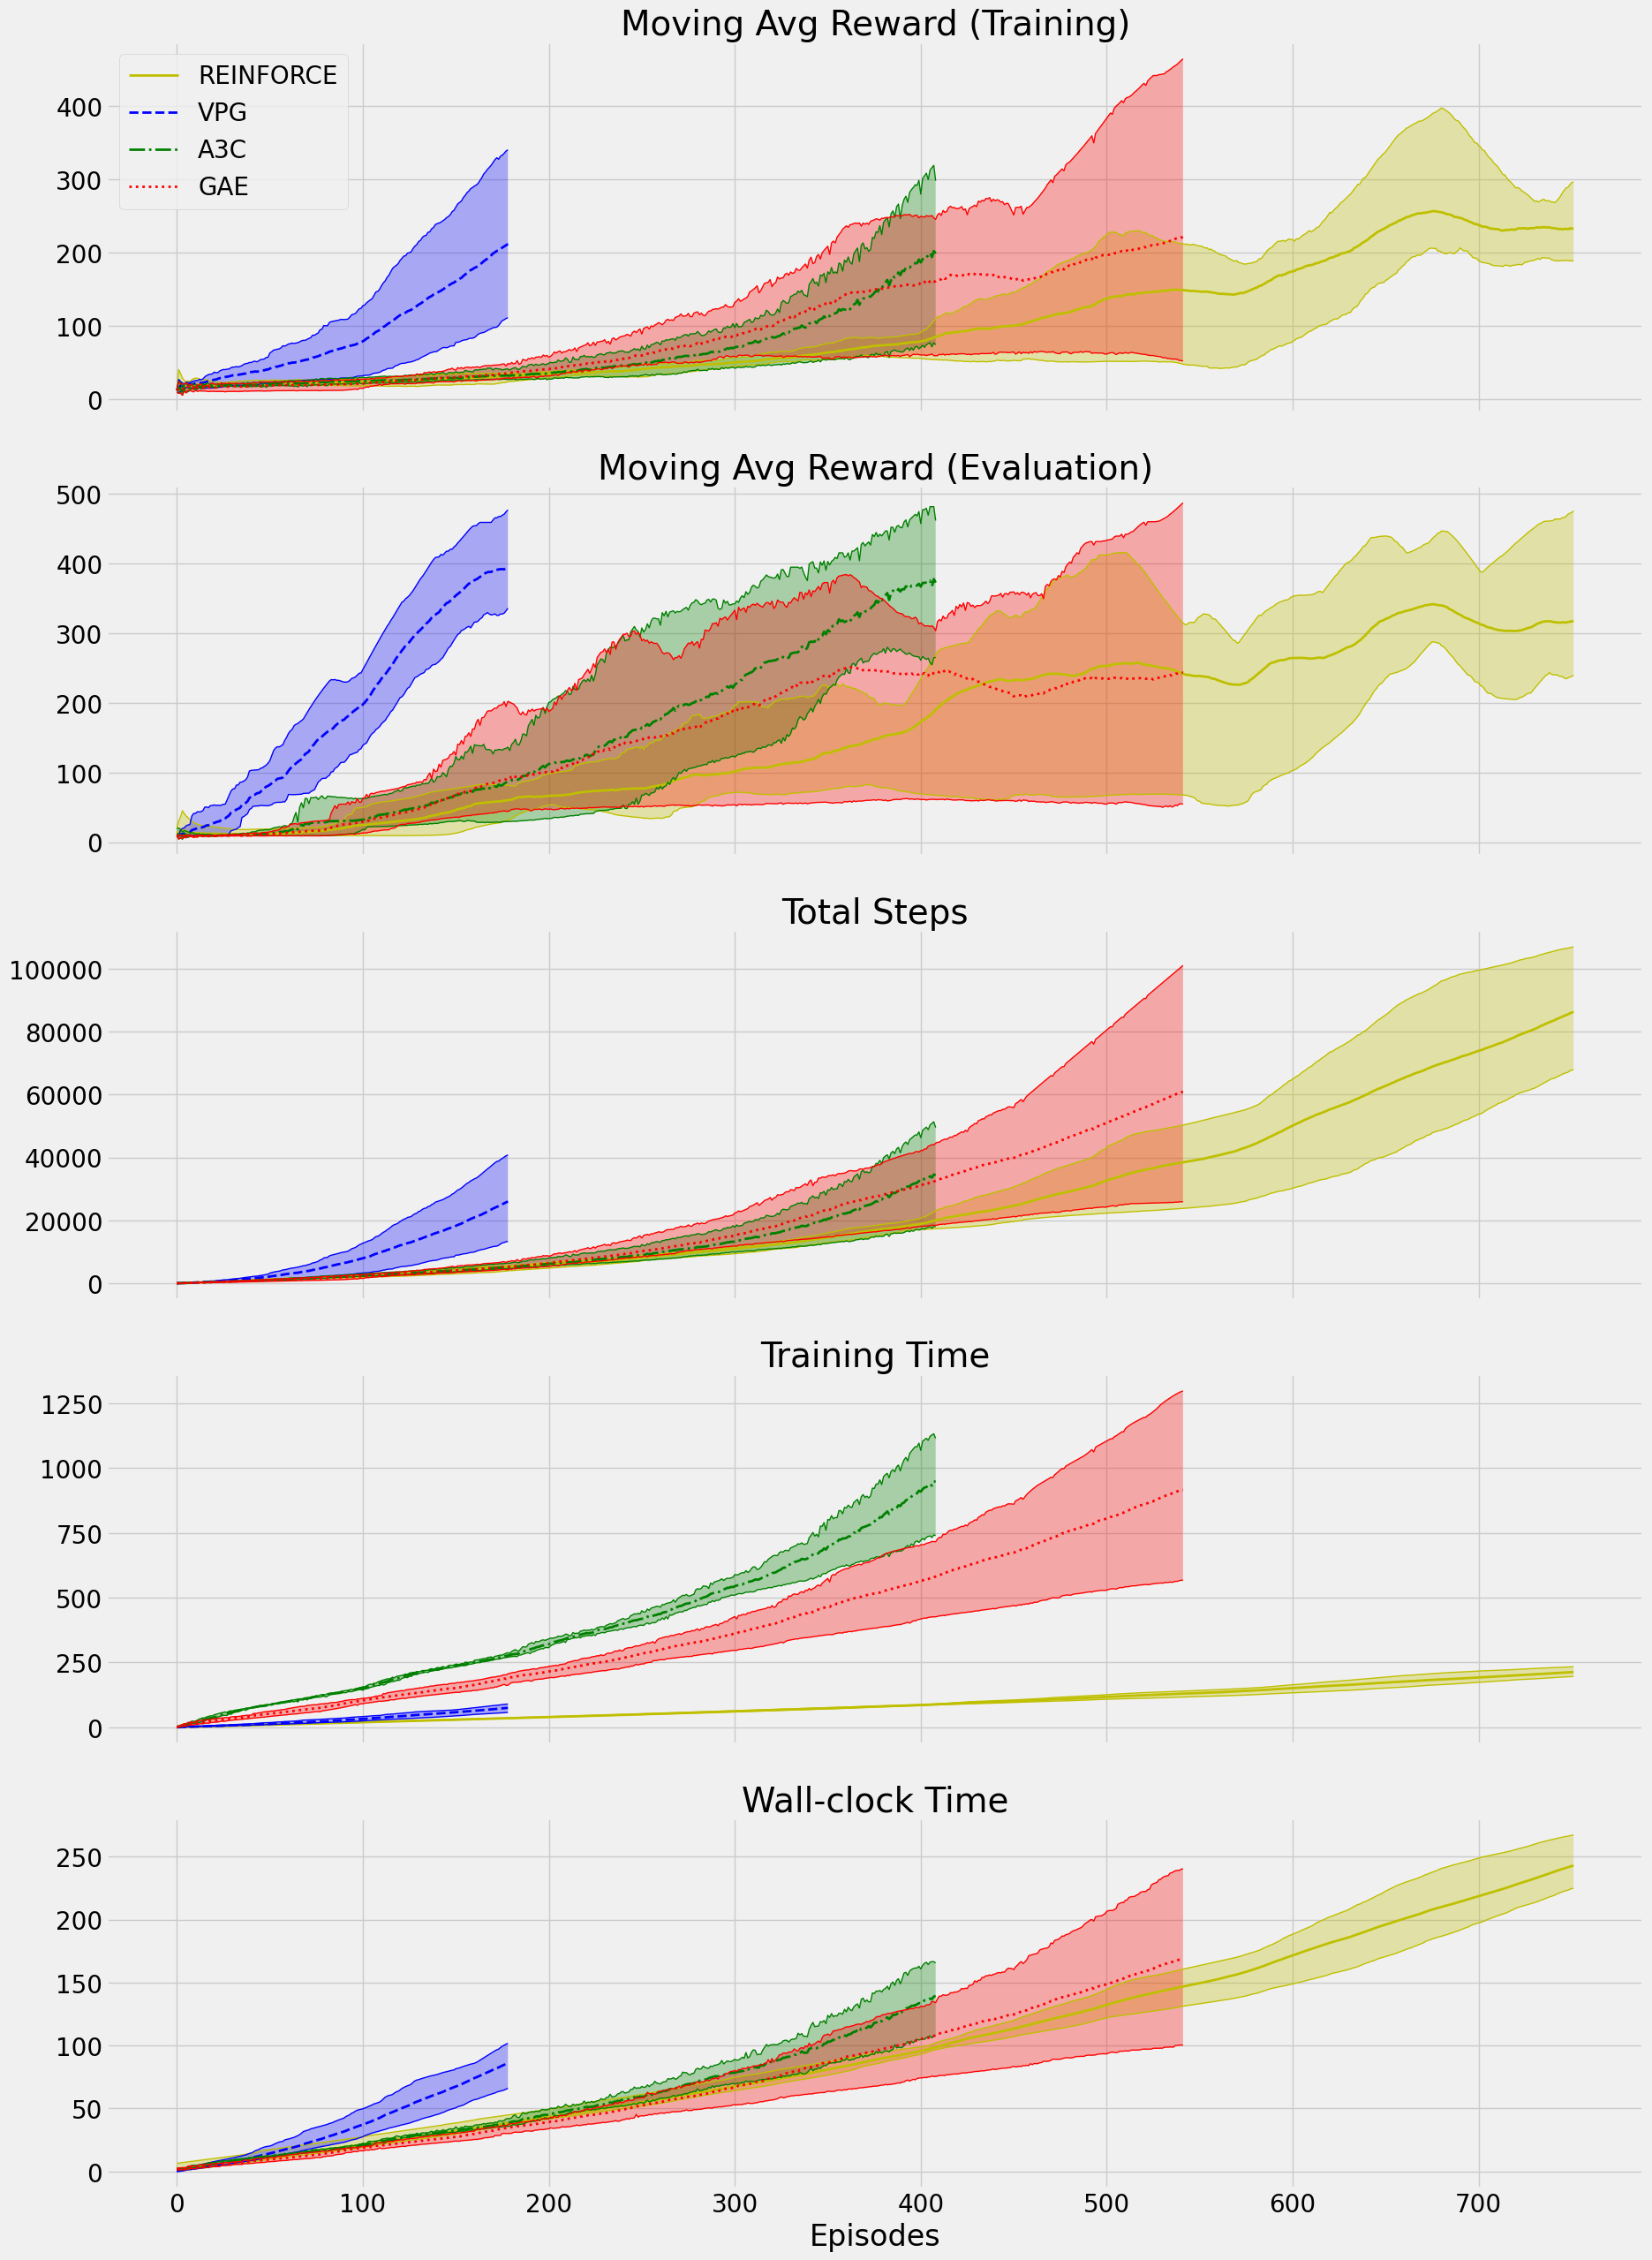

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(gae_max_rt, 'r', linewidth=1)
axs[4].plot(gae_min_rt, 'r', linewidth=1)
axs[4].plot(gae_mean_rt, 'r:', label='GAE', linewidth=2)
axs[4].fill_between(gae_x, gae_min_rt, gae_max_rt, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# A2C
**Advantage Actor-Critic** (A2C) is synchronous version of A3C. In A2C we have multiple actors with a single learner.


## FCAC
Fully Connected Actor-Critic

In [ ]:
# weight-sharing actor-critic neural network
class FCAC(nn.Module): # Fully Connected Actor-Critic
  def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super().__init__()
    self.activation_fc = activation_fc
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)
    self.value_output_layer = nn.Linear(hidden_dims[-1],1) # dim of value is 1
    self.policy_output_layer = nn.Linear(hidden_dims[-1], output_dim)

  def _format(self, state):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      if len(x.size()) == 1:
        x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    return self.policy_output_layer(x), self.value_output_layer(x)

  def full_pass(self, state):
    """convinience method to obtain probs, actions etc. needed for training
    * action - return an action that can be directly passed into the env
    * is_exploratory - flag indicating whether the action was exploratory
    * logpa - log prob of the action
    * entropy - entropy of the policy
    """
    logits, value = self.forward(state) # logits are preferences over actions
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    logpa = dist.log_prob(action).unsqueeze(-1) # log probability of the action
    entropy = dist.entropy().unsqueeze(-1)
    action = action.item() if len(action)==1 else action.data.numpy()
    is_exploratory = action != np.argmax(logits.detach().numpy(), axis=int(len(state)!=1))
    return action, is_exploratory, logpa, entropy, value

  def select_action(self, state):
    logits, _ = self.forward(state)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    action = action.item() if len(action)==1 else action.data.numpy()
    return action

  # select the greedy action according to the policy
  def select_greedy_action(self, state):
    logits, _ = self.forward(state)
    return np.argmax(logits.detach().numpy())

  def evaluate_state(self, state):
    _, value = self.forward(state)
    return value


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Multi-process Environment
In A2C, we have a single agent driving the interaction with the environment. But, in this case the environent is a multi-process class that gathers samples from multiple environments at once.

The neural networks now need to porcess batches of data. Which means in A2C we can take advantage of GPUs, unlike A3C in which CPUs are the most important resource.

In [ ]:
class MultiprocessEnv(object):
  def __init__(self, meke_env_fn, make_env_kargs, seed, n_workers):
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.n_workers = n_workers
    # pipes to communicate with workers; mp.Pipe() returns a tuple: (parent, child)
    # representing parent end of the connection and child end, respectively.
    self.pipes = [mp.Pipe() for rank in range(self.n_workers)]
    # create workers
    self.workers = [
        mp.Process(
            target=self.work,
            args=(rank, self.pipes[rank][1])
        ) for rank in range(self.n_workers)
    ]
    [w.start() for w in self.workers]
    self.dones = {rank:False for rank in range(self.n_workers)}

  def reset(self, rank=None, **kwargs):
    if rank is not None:
      parent_end, _ = self.pipes[rank]
      self.send_msg(('reset', {}), rank)
      o = parent_end.recv()
      return o
    self.broadcast_msg(('reset', kwargs))
    return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])

  def step(self, actions):
    assert len(actions) == self.n_workers
    # broadcast the command and arguments to all workers
    [self.send_msg( ('step', {'action':actions[rank]}), rank) for rank in range(self.n_workers)]
    results = []
    for rank in range(self.n_workers):
      parent_end, _ = self.pipes[rank]
      o, r, d, i = parent_end.recv() # observations, rewards, dones, infos
      results.append( (o,
                       np.array(r, dtype=np.float32),
                       np.array(d, dtype=np.float32),
                       i))
    return [np.vstack(block) for block in np.array(results, dtype=np.object_).T]

  def close(self, **kwargs):
    self.broadcast_msg(('close', kwargs))
    [w.join() for w in self.workers]

  def _past_limit(self, **kwargs):
    self.broadcast_msg(('_past_limit', kwargs))
    return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])

  def work(self, rank, worker_end):
    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed+rank)
    while True:
      cmd, kwargs = worker_end.recv() # listen for commands
      # each command calls the respective env function and sends the response
      # back to parent process.
      if cmd == 'reset':
        worker_end.send(env.reset(**kwargs))
      elif cmd == 'step':
        worker_end.send(env.step(**kwargs))
      elif cmd == '_past_limit':
        worker_end.send(env._elapsed_steps >= env._max_episode_steps)
      else:
        env.close(**kwargs) ; del env ; worker_end.close()
        break

  def send_msg(self, msg, rank):
    parent_end, _ = self.pipes[rank]
    parent_end.send(msg)

  def broadcast_msg(self, msg):
    [parent_end.send(msg) for parent_end, _ in self.pipes]

## A2C

In [ ]:
class A2C():
  def __init__(self,
               ac_model_fn, # basically use FCAC
               ac_model_max_grad_norm, # for clipping gradients of NN params
               ac_optimizer_fn,
               ac_optimizer_lr,
               policy_loss_weight,
               value_loss_weight,
               entropy_loss_weight,
               max_n_steps,
               n_workers,
               tau):
    assert n_workers > 1
    self.ac_model_fn = ac_model_fn
    self.ac_model_max_grad_norm = ac_model_max_grad_norm
    self.ac_optimizer_fn = ac_optimizer_fn
    self.ac_optimizer_lr = ac_optimizer_lr

    self.policy_loss_weight = policy_loss_weight
    self.value_loss_weight = value_loss_weight
    self.entropy_loss_weight = entropy_loss_weight

    self.max_n_steps = max_n_steps
    self.n_workers = n_workers
    self.tau = tau


  def optimize_model(self):
    logpas = torch.stack(self.logpas).squeeze()
    entropies = torch.stack(self.entropies).squeeze()
    values = torch.stack(self.values).squeeze()

    # similar to VPG, but using input params instead of self.*
    T = len(self.rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    rewards = np.array(self.rewards).squeeze()
    # work with matrices with vectors of timesteps per worker
    returns = np.array([[np.sum(discounts[:T-t] * rewards[t:, w]) for t in range(T)]
                          for w in range(self.n_workers)])
    np_values = values.data.numpy()
    tau_discounts = np.logspace(0, T-1, num=T-1, base=self.gamma*self.tau, endpoint=False)
    advs = rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]
    gaes = np.array([[np.sum(tau_discounts[:T-1-t] * advs[t:, w]) for t in range(T-1)]
                          for w in range(self.n_workers)])
    discounted_gaes = discounts[:-1] * gaes

    values = values[:-1,...].view(-1).unsqueeze(1)
    logpas = logpas.view(-1).unsqueeze(1)
    entropies = entropies.view(-1).unsqueeze(1)
    # returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    # print(f'dim={returns.shape} .T[:-1] dim={returns.T[:-1].shape} floatTensor dim={torch.FloatTensor(returns.T[:-1]).shape}')
    # a=torch.FloatTensor(returns.T[:-1]).reshape(-1)
    # print(f'view(-1) dim={a.shape}')
    returns = torch.FloatTensor(returns.T[:-1]).reshape(-1).unsqueeze(1)
    discounted_gaes = torch.FloatTensor(discounted_gaes.T).reshape(-1).unsqueeze(1)

    T -= 1
    T *= self.n_workers
    assert returns.size() == (T, 1)
    assert values.size() == (T, 1)
    assert logpas.size() == (T, 1)
    assert entropies.size() == (T, 1)

    # calc the value_error to use it to score the log-probs or the actions.
    value_error = returns.detach() - values # adv fn: G_t-V(S_t; phi)
    value_loss = value_error.pow(2).mul(0.5).mean()
    # we want to maximise the performance measure J, so put '-' in front
    policy_loss = -(discounted_gaes.detach() * logpas).mean()
    entropy_loss = -entropies.mean()
    # build a single loss functions from the multi-processing envs
    loss = self.policy_loss_weight * policy_loss + \
                self.value_loss_weight * value_loss + \
                self.entropy_loss_weight * entropy_loss

    # back prop and optimise a single neural network
    self.ac_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.ac_model.parameters(),
                                   self.ac_model_max_grad_norm)
    self.ac_optimizer.step()

  def interaction_step(self, states, envs):
    actions, is_exploratory, logpas, entropies, values = self.ac_model.full_pass(states)
    new_states, rewards, is_terminals, _ = envs.step(actions)

    self.logpas.append(logpas)
    self.entropies.append(entropies)
    self.rewards.append(rewards)
    self.values.append(values)

    self.running_reward += rewards
    self.running_timestep += 1
    self.running_exploration += is_exploratory[:,np.newaxis].astype(np.int32)

    return new_states, is_terminals

  def train(self, make_envs_fn, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_envs_fn = make_envs_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    # create vectorised environments
    envs = self.make_envs_fn(make_env_fn, make_env_kargs, self.seed, self.n_workers)
    nS, nA = env.observation_space.shape[0], env.action_space.n
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    self.running_timestep = np.array([[0.],] * self.n_workers)
    self.running_reward = np.array([[0.],] * self.n_workers)
    self.running_exploration = np.array([[0.],] * self.n_workers)
    self.running_seconds = np.array([[time.time()],] * self.n_workers)
    self.episode_timestep, self.episode_reward = [], []
    self.episode_seconds, self.evaluation_scores = [], []
    self.episode_exploration = []

    # this is the single actor-critic model with policy and vlaue outputs
    self.ac_model = self.ac_model_fn(nS, nA)
    self.ac_optimizer = self.ac_optimizer_fn(self.ac_model,
                                             self.ac_optimizer_lr)
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    states = envs.reset() # reset multi-processor envs and returns a stack of states

    # collect n_steps rollout
    episode, n_steps_start = 0, 0
    self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
    for step in count(start=1):
      # works with stacks of states and is_terminals now
      states, is_terminals = self.interaction_step(states, envs)

      if is_terminals.sum() or step - n_steps_start == self.max_n_steps:
        past_limits_enforced = envs._past_limit()
        # use np.logical... on vectors
        is_failure = np.logical_and(is_terminals, np.logical_not(past_limits_enforced))
        next_values = self.ac_model.evaluate_state(states).detach().numpy() * (1 - is_failure)
        self.rewards.append(next_values) ; self.values.append(torch.Tensor(next_values))
        self.optimize_model()
        self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
        n_steps_start = step

      # stats
      if is_terminals.sum():
          episode_done = time.time()
          evaluation_score, _ = self.evaluate(self.ac_model, env)
          self.save_checkpoint(episode, self.ac_model)

          for i in range(self.n_workers):
            if is_terminals[i]:
              states[i] = envs.reset(rank=i)
              self.episode_timestep.append(self.running_timestep[i][0])
              self.episode_reward.append(self.running_reward[i][0])
              self.episode_exploration.append(self.running_exploration[i][0]/self.running_timestep[i][0])
              self.episode_seconds.append(episode_done - self.running_seconds[i][0])
              training_time += self.episode_seconds[-1]
              self.evaluation_scores.append(evaluation_score)
              episode += 1

              mean_10_reward = np.mean(self.episode_reward[-10:])
              std_10_reward = np.std(self.episode_reward[-10:])
              mean_100_reward = np.mean(self.episode_reward[-100:])
              std_100_reward = np.std(self.episode_reward[-100:])
              mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
              std_100_eval_score = np.std(self.evaluation_scores[-100:])
              mean_100_exp_rat = np.mean(self.episode_exploration[-100:])
              std_100_exp_rat = np.std(self.episode_exploration[-100:])

              total_step = int(np.sum(self.episode_timestep))
              wallclock_elapsed = time.time() - training_start
              result[episode-1] = total_step, mean_100_reward, \
                  mean_100_eval_score, training_time, wallclock_elapsed

          # debug stuff
          reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
          reached_max_minutes = wallclock_elapsed >= max_minutes * 60
          reached_max_episodes = episode + self.n_workers >= max_episodes
          reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
          training_is_over = reached_max_minutes or \
                              reached_max_episodes or \
                              reached_goal_mean_reward

          elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
          debug_message = 'el {}, ep {:04}, ts {:06}, '
          debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
          debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
          debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
          debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
          debug_message = debug_message.format(
              elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
              mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
              mean_100_eval_score, std_100_eval_score)
          print(debug_message, end='\r', flush=True)
          if reached_debug_time or training_is_over:
              print(ERASE_LINE + debug_message, flush=True)
              last_debug_time = time.time()
          if training_is_over:
              if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
              if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
              if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
              break

          # reset running variables for next time around
          self.running_timestep *= 1 - is_terminals
          self.running_reward *= 1 - is_terminals
          self.running_exploration *= 1 - is_terminals
          self.running_seconds[is_terminals.astype(np.bool_)] = time.time()

    final_eval_score, score_std = self.evaluate(self.ac_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
          ' {:.2f}s wall-clock time.\n'.format(
              final_eval_score, score_std, training_time, wallclock_time))
    env.close() ; del env
    envs.close() ; del envs
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time


  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    #print(f'checkpoint_dir {self.checkpoint_dir}')
    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))

    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int32)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.ac_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.ac_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.ac_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.ac_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    #print(f"save_checkpoint {episode_idx} !!!!!!!!!!!!!!!!")
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train A2C

In [ ]:
a2c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
    'env_name': 'CartPole-v1',
    'gamma': 0.99,
    'max_minutes': 10,
    'max_episodes': 10000,
    'goal_mean_100_reward': 475
  }

  ac_model_fn = lambda nS, nA: FCAC(nS, nA, hidden_dims=(256,128))
  ac_model_max_grad_norm = 1
  # ac_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
  ac_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  ac_optimizer_lr = 0.001

  policy_loss_weight = 1.0
  value_loss_weight = 0.6

  entropy_loss_weight = 0.001

  max_n_steps = 10
  n_workers = 8
  tau = 0.95

  env_name, gamma, max_minutes, \
  max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = A2C(ac_model_fn,
              ac_model_max_grad_norm,
              ac_optimizer_fn,
              ac_optimizer_lr,
              policy_loss_weight,
              value_loss_weight,
              entropy_loss_weight,
              max_n_steps,
              n_workers,
              tau)

  make_envs_fn = lambda mef, mea, s, n: MultiprocessEnv(mef, mea, s, n)
  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallclock_time = agent.train(make_envs_fn,
                                                                        make_env_fn,
                                                                        make_env_kargs,
                                                                        seed,
                                                                        gamma,
                                                                        max_minutes,
                                                                        max_episodes,
                                                                        goal_mean_100_reward)
  a2c_results.append(result)
  if final_eval_score > best_eval_score:
      best_eval_score = final_eval_score
      best_agent = agent
a2c_results = np.array(a2c_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


el 00:00:00, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.7±0.0, ev 028.0±000.0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


el 00:01:00, ep 0569, ts 060121, ar 10 346.2±055.9, 100 200.7±089.3, ex 100 0.2±0.0, ev 238.7±131.6
el 00:01:43, ep 0701, ts 106231, ar 10 500.0±000.0, 100 386.3±154.1, ex 100 0.2±0.0, ev 477.0±059.0
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 770.99s training time, 116.49s wall-clock time.

el 00:00:00, ep 0000, ts 000009, ar 10 009.0±000.0, 100 009.0±000.0, ex 100 0.9±0.0, ev 037.0±000.0
el 00:01:00, ep 0551, ts 059087, ar 10 286.7±139.1, 100 242.6±155.7, ex 100 0.3±0.0, ev 349.3±129.7
el 00:01:57, ep 0697, ts 115404, ar 10 500.0±000.0, 100 426.8±137.6, ex 100 0.2±0.0, ev 477.1±062.5
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 884.62s training time, 129.23s wall-clock time.

el 00:00:00, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 008.0±000.0
el 00:01:01, ep 0463, ts 039727, ar 10 220.9±096.5, 100 143.2±084.6, ex 100 0.3±0.0, ev 204.3±134.9
el 00:02:02, ep 0570, ts 0

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: http


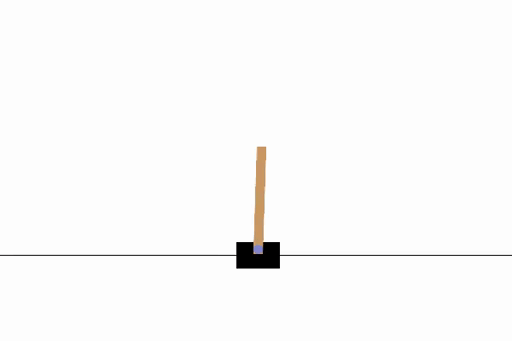
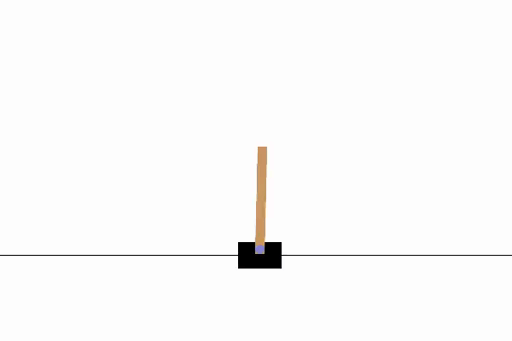

In [ ]:
best_agent.demo_progression()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



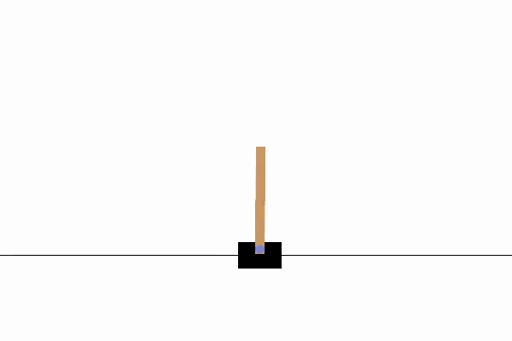
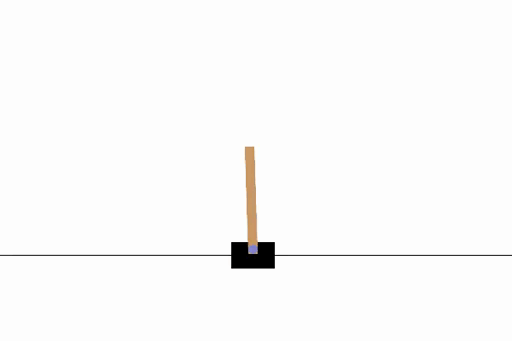

In [ ]:
best_agent.demo_last()

In [ ]:
a2c_max_t, a2c_max_r, a2c_max_s, a2c_max_sec, a2c_max_rt = np.max(a2c_results, axis=0).T
a2c_min_t, a2c_min_r, a2c_min_s, a2c_min_sec, a2c_min_rt = np.min(a2c_results, axis=0).T
a2c_mean_t, a2c_mean_r, a2c_mean_s, a2c_mean_sec, a2c_mean_rt = np.mean(a2c_results, axis=0).T
a2c_x = np.arange(np.max(
    (len(a2c_mean_s), len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [ ]:
a2c_root_dir = os.path.join(RESULTS_DIR, 'a2c')
not os.path.exists(a2c_root_dir) and os.makedirs(a2c_root_dir)

np.save(os.path.join(a2c_root_dir, 'x'), a2c_x)

np.save(os.path.join(a2c_root_dir, 'max_r'), a2c_max_r)
np.save(os.path.join(a2c_root_dir, 'min_r'), a2c_min_r)
np.save(os.path.join(a2c_root_dir, 'mean_r'), a2c_mean_r)

np.save(os.path.join(a2c_root_dir, 'max_s'), a2c_max_s)
np.save(os.path.join(a2c_root_dir, 'min_s'), a2c_min_s )
np.save(os.path.join(a2c_root_dir, 'mean_s'), a2c_mean_s)

np.save(os.path.join(a2c_root_dir, 'max_t'), a2c_max_t)
np.save(os.path.join(a2c_root_dir, 'min_t'), a2c_min_t)
np.save(os.path.join(a2c_root_dir, 'mean_t'), a2c_mean_t)

np.save(os.path.join(a2c_root_dir, 'max_sec'), a2c_max_sec)
np.save(os.path.join(a2c_root_dir, 'min_sec'), a2c_min_sec)
np.save(os.path.join(a2c_root_dir, 'mean_sec'), a2c_mean_sec)

np.save(os.path.join(a2c_root_dir, 'max_rt'), a2c_max_rt)
np.save(os.path.join(a2c_root_dir, 'min_rt'), a2c_min_rt)
np.save(os.path.join(a2c_root_dir, 'mean_rt'), a2c_mean_rt)

## load from files

In [ ]:
!rm -f results/a2c/*
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/x.npy

In [ ]:
a2c_root_dir = os.path.join(RESULTS_DIR, 'a2c')

a2c_x = np.load(os.path.join(a2c_root_dir, 'x.npy'))

a2c_max_r = np.load(os.path.join(a2c_root_dir, 'max_r.npy'))
a2c_min_r = np.load(os.path.join(a2c_root_dir, 'min_r.npy'))
a2c_mean_r = np.load(os.path.join(a2c_root_dir, 'mean_r.npy'))

a2c_max_s = np.load(os.path.join(a2c_root_dir, 'max_s.npy'))
a2c_min_s = np.load(os.path.join(a2c_root_dir, 'min_s.npy'))
a2c_mean_s = np.load(os.path.join(a2c_root_dir, 'mean_s.npy'))

a2c_max_t = np.load(os.path.join(a2c_root_dir, 'max_t.npy'))
a2c_min_t = np.load(os.path.join(a2c_root_dir, 'min_t.npy'))
a2c_mean_t = np.load(os.path.join(a2c_root_dir, 'mean_t.npy'))

a2c_max_sec = np.load(os.path.join(a2c_root_dir, 'max_sec.npy'))
a2c_min_sec = np.load(os.path.join(a2c_root_dir, 'min_sec.npy'))
a2c_mean_sec = np.load(os.path.join(a2c_root_dir, 'mean_sec.npy'))

a2c_max_rt = np.load(os.path.join(a2c_root_dir, 'max_rt.npy'))
a2c_min_rt = np.load(os.path.join(a2c_root_dir, 'min_rt.npy'))
a2c_mean_rt = np.load(os.path.join(a2c_root_dir, 'mean_rt.npy'))

## Plotting A2C


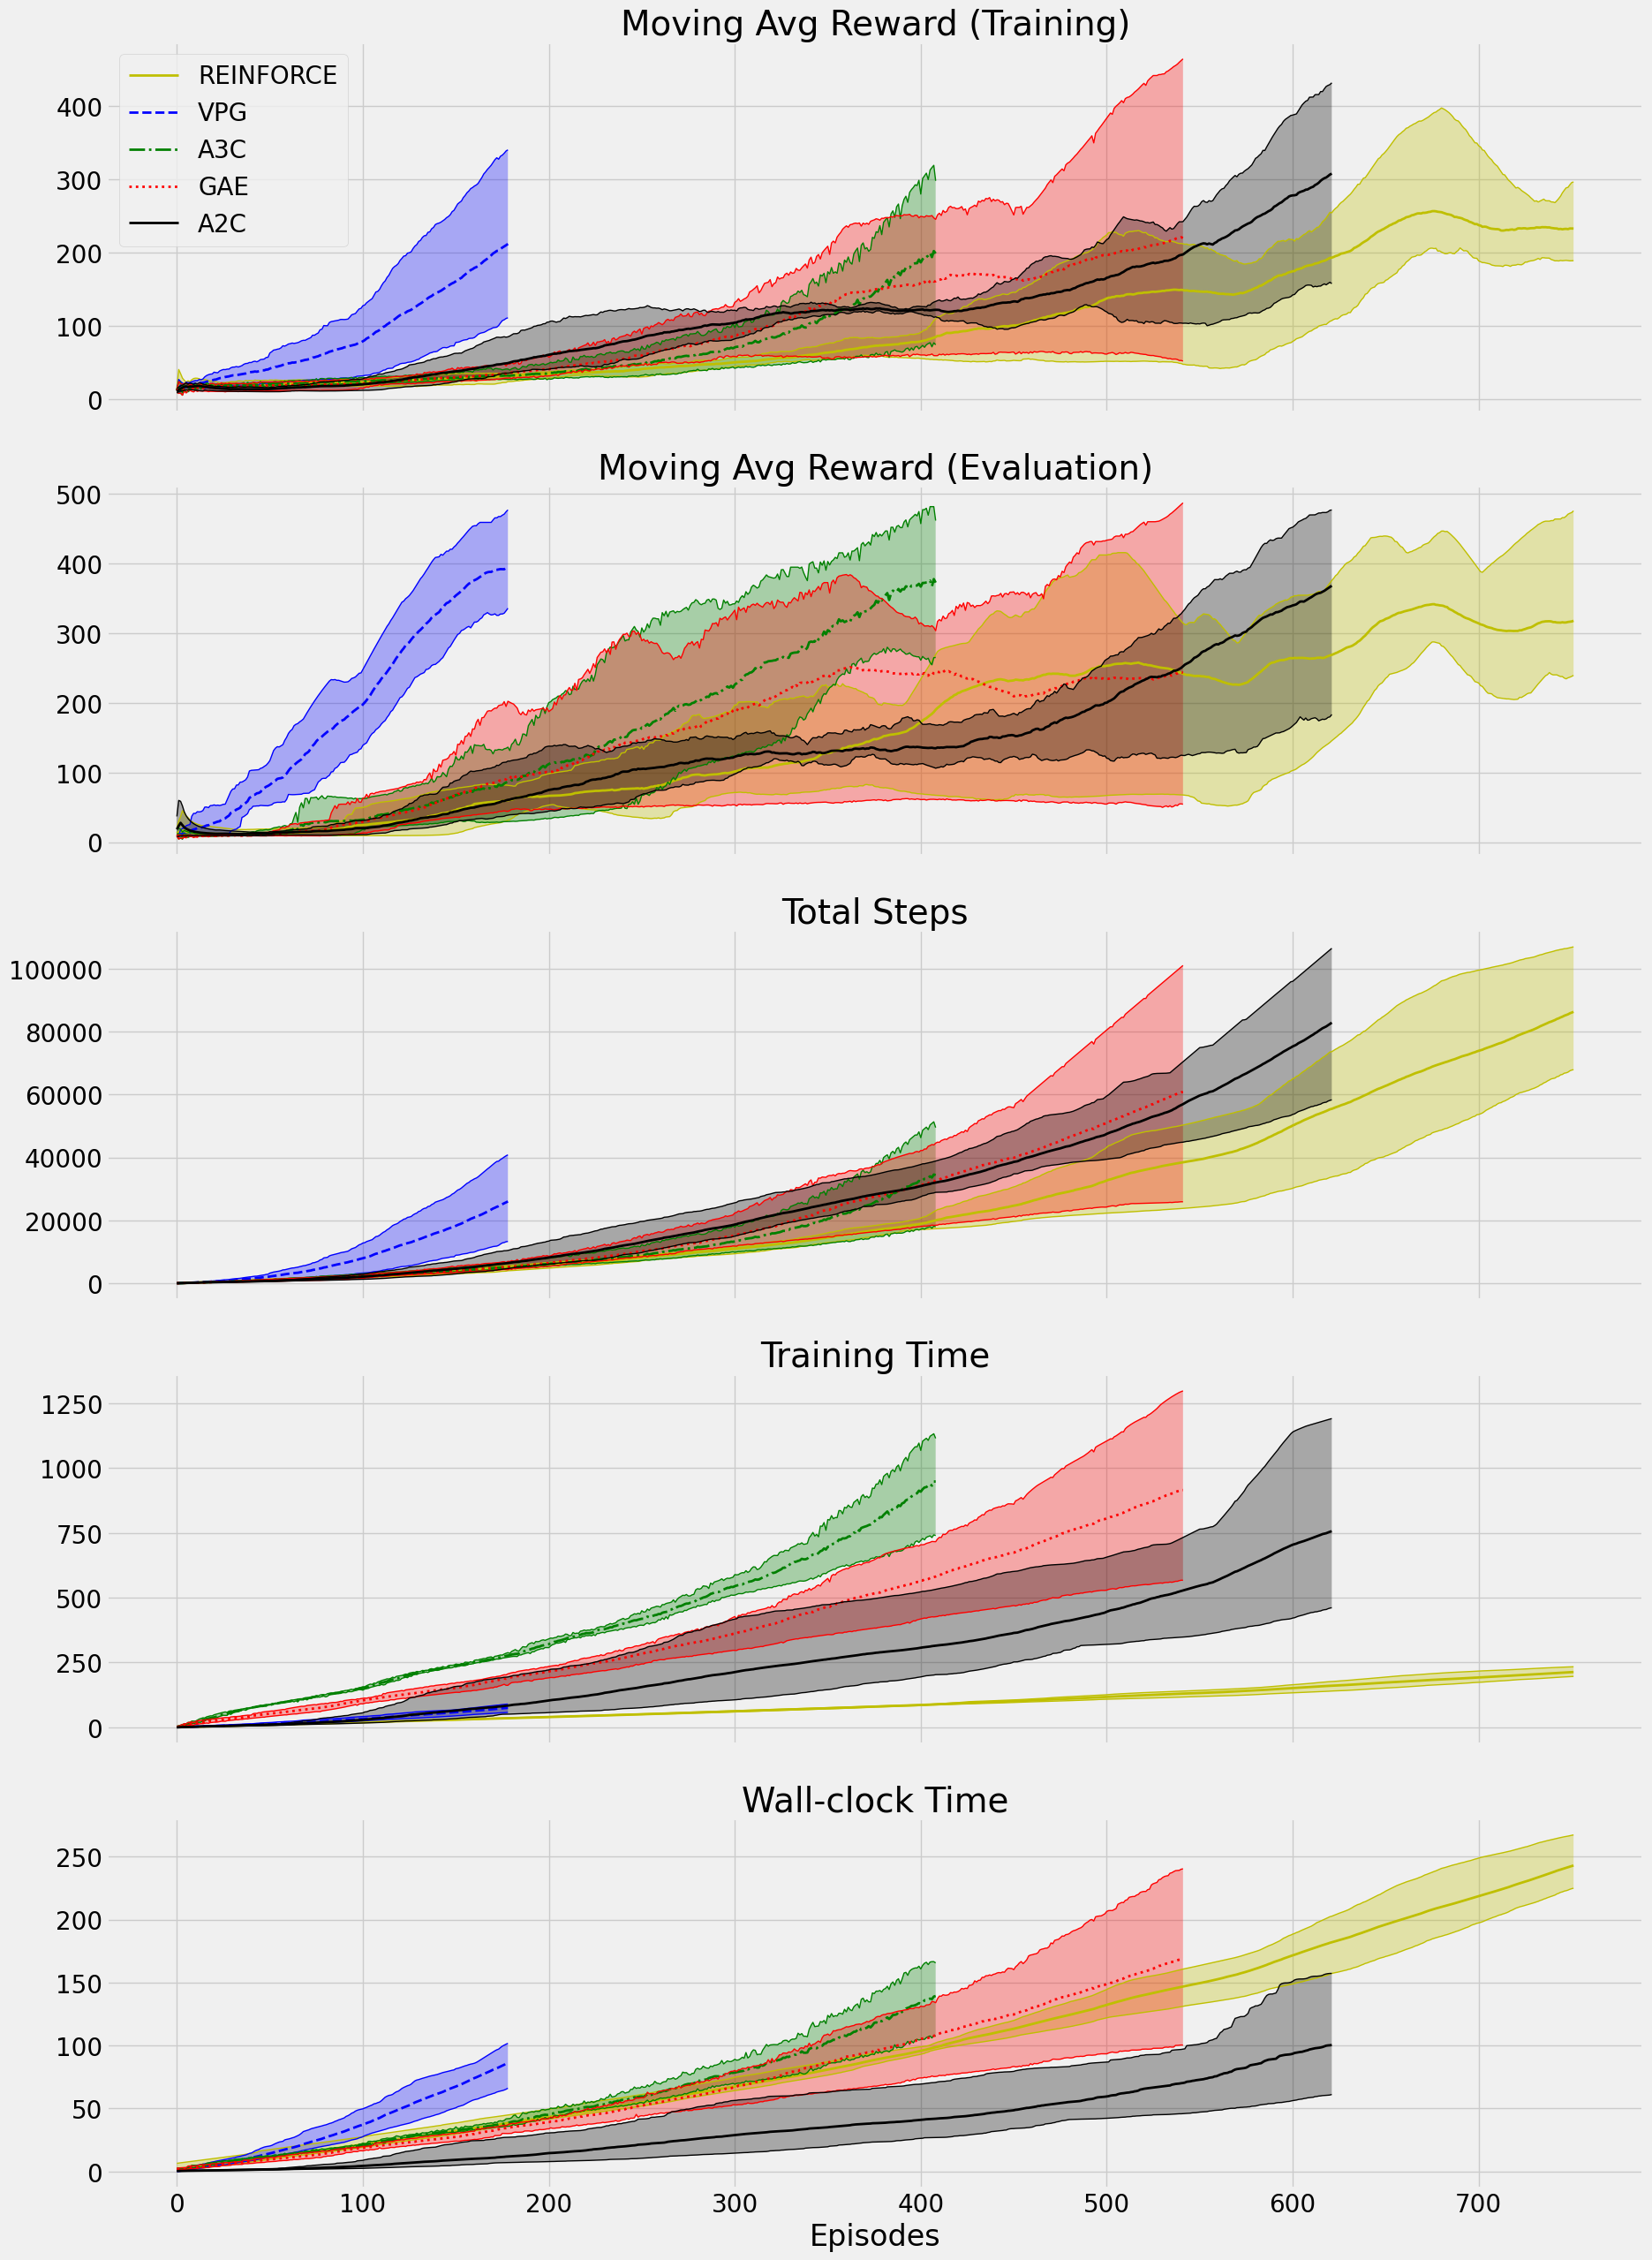

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(gae_max_rt, 'r', linewidth=1)
axs[4].plot(gae_min_rt, 'r', linewidth=1)
axs[4].plot(gae_mean_rt, 'r:', label='GAE', linewidth=2)
axs[4].fill_between(gae_x, gae_min_rt, gae_max_rt, facecolor='r', alpha=0.3)

# A2C
axs[0].plot(a2c_max_r, 'k', linewidth=1)
axs[0].plot(a2c_min_r, 'k', linewidth=1)
axs[0].plot(a2c_mean_r, 'k', label='A2C', linewidth=2)
axs[0].fill_between(a2c_x, a2c_min_r, a2c_max_r, facecolor='k', alpha=0.3)

axs[1].plot(a2c_max_s, 'k', linewidth=1)
axs[1].plot(a2c_min_s, 'k', linewidth=1)
axs[1].plot(a2c_mean_s, 'k', label='A2C', linewidth=2)
axs[1].fill_between(a2c_x, a2c_min_s, a2c_max_s, facecolor='k', alpha=0.3)

axs[2].plot(a2c_max_t, 'k', linewidth=1)
axs[2].plot(a2c_min_t, 'k', linewidth=1)
axs[2].plot(a2c_mean_t, 'k', label='A2C', linewidth=2)
axs[2].fill_between(a2c_x, a2c_min_t, a2c_max_t, facecolor='k', alpha=0.3)

axs[3].plot(a2c_max_sec, 'k', linewidth=1)
axs[3].plot(a2c_min_sec, 'k', linewidth=1)
axs[3].plot(a2c_mean_sec, 'k', label='A2C', linewidth=2)
axs[3].fill_between(a2c_x, a2c_min_sec, a2c_max_sec, facecolor='k', alpha=0.3)

axs[4].plot(a2c_max_rt, 'k', linewidth=1)
axs[4].plot(a2c_min_rt, 'k', linewidth=1)
axs[4].plot(a2c_mean_rt, 'k', label='A2C', linewidth=2)
axs[4].fill_between(a2c_x, a2c_min_rt, a2c_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

* from first 2 charts, VPG is more sample efficient than morecomplex methods,
such as A3C or A2C. This is mostly because these two
methods use multiple workers, which initially cost lots of
data to get only a bit of progress.
* from Total Steps: REINFORCE alone is too inefficient to be a practical algorithm.
* However, from Training Time, REINFORCE uses very little resources. Also notice how algorithms with workers consume much more compute.
* Interestingly, from Wall-Clock Time, parallel methods
and incredibly fast averaging ~10 seconds to solve cart pole v1! The 600 steps version. Impressive!

utils

In [ ]:
s="""!rm -f results/gae/*
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/x.npy
"""
fr, to ='gae', 'a2c'
print(s.replace(fr, to))

!rm -f results/a2c/*
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/ma

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
s="""reinforce_root_dir = os.path.join(RESULTS_DIR, 'reinforce')
not os.path.exists(reinforce_root_dir) and os.makedirs(reinforce_root_dir)

np.save(os.path.join(reinforce_root_dir, 'x'), reinforce_x)

np.save(os.path.join(reinforce_root_dir, 'max_r'), reinforce_max_r)
np.save(os.path.join(reinforce_root_dir, 'min_r'), reinforce_min_r)
np.save(os.path.join(reinforce_root_dir, 'mean_r'), reinforce_mean_r)

np.save(os.path.join(reinforce_root_dir, 'max_s'), reinforce_max_s)
np.save(os.path.join(reinforce_root_dir, 'min_s'), reinforce_min_s )
np.save(os.path.join(reinforce_root_dir, 'mean_s'), reinforce_mean_s)

np.save(os.path.join(reinforce_root_dir, 'max_t'), reinforce_max_t)
np.save(os.path.join(reinforce_root_dir, 'min_t'), reinforce_min_t)
np.save(os.path.join(reinforce_root_dir, 'mean_t'), reinforce_mean_t)

np.save(os.path.join(reinforce_root_dir, 'max_sec'), reinforce_max_sec)
np.save(os.path.join(reinforce_root_dir, 'min_sec'), reinforce_min_sec)
np.save(os.path.join(reinforce_root_dir, 'mean_sec'), reinforce_mean_sec)

np.save(os.path.join(reinforce_root_dir, 'max_rt'), reinforce_max_rt)
np.save(os.path.join(reinforce_root_dir, 'min_rt'), reinforce_min_rt)
np.save(os.path.join(reinforce_root_dir, 'mean_rt'), reinforce_mean_rt)
"""
fr, to ='reinforce', 'ddpg'
print(s.replace(fr, to))